# Предсказания риска сердечных приступов

## 1 Описание проекта

В этом проекте предполагается работа с датасетом из открытого источника. Потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. В начале проекта доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов. Метрика на тестовом датасете будет измерена в ходе проверки работы. Также будет доступен скрипт, с помощью которого будет измеряться финальная метрика полученной модели.

## 2 Задачи

- Исследовать датасет (предполагается поиск дополнительной информации для лучшего понимания природы данных).
- Предобработать данные. Нужно быть внимательным: в данных могут быть бесполезные признаки, сильно скорелированные признаки, а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных.
- Найти наиболее подходящую модель и обучить её.
- Подготовить предсказания на тестовой выборке. Файл предсказаний должен быть в `csv` формате и содержать 2 столбца: `id` и `prediction`. 
- Подготовить скрипт и библиотеки для обработки данных и предсказания на тестовой выборке.
- Написать инструмент для тестирования.
- Оформить документацию.

## 3 Описание данных

Данные пациентов для предсказания риска сердечных приступов:
- `id` - уникальный идентификатор пациента.
- `Age` - возраст пациента.
- `Cholesterol` (холестерин) - это жироподобное вещество, необходимое для нормального функционирования организма, которое вырабатывается в печени и поступает с пищей. Он служит строительным материалом для клеточных мембран, участвует в выработке гормонов, витамина D и желчных кислот.
- `Heart rate` (ЧСС) - это показатель, который отражает частоту сердечных сокращений за единицу времени, обычно измеряемый в ударах в минуту (уд/мин).
- `Diabetes` (сахарный диабет) - группа эндокринных заболеваний, связанных с нарушением усвоения глюкозы вследствие абсолютной или относительной (нарушение взаимодействия с клетками-мишенями) недостаточности гормона инсулина.
- `Family History` (семейный анамнез или семейная история) - наблюдались ли проблемы с сердцем у ближайших родственников (родителей, братьев, сестер).
- `Smoking` - курит ли пациент.
- `Obesity` - есть ли ожирение.
- `Alcohol Consumption` - употребляет ли пациент алкоголь.
- `Exercise Hours Per Week` - количество часов тренировок в неделю.
- `Diet` - Номер диеты.
- `Previous Heart Problems` - были ли проблемы с сердцем в прошлом.
- `Medication Use` - принимает ли пациент лекарственные препараты.
- `Stress Level` - уровень стресса.
- `Sedentary Hours Per Day` - число сидячих часов в день.
- `Income` - доход пациента.
- `BMI` (ИМТ) - индекс массы тела.
- `Triglycerides` (триглицериды) — это тип жиров в крови, которые служат основным источником энергии для организма, откладываясь в жировой ткани на хранение.
- `Physical Activity Days Per Week` - количество дней физической активности в неделю.
- `Sleep Hours Per Day` - количество часов сна в день.
- `Heart Attack Risk (Binary)` - риск сердечного приступа (целевой признак).
- `Blood sugar` - содержание сахара в крови.
- `CK-MB` (креатинкиназа-МВ) – это фермент, который является биомаркером повреждения сердечной мышцы, в первую очередь, при инфаркте миокарда.
- `Troponin` (Тропонин) — это белок, обнаружение которого в крови сигнализирует о повреждении сердечной мышцы (миокарда), чаще всего при инфаркте миокарда.
- `Gender` - пол пациента.
- `Systolic blood pressure` (Систолическое артериальное давление) - давление в момент сокращения сердечной мышцы.
- `Diastolic blood pressure` (Диастолическое артериальное давление) - давление в момент расслабления сердечной мышцы между ударами. 

Тренировочные данные содержатся в `heart_train.csv`, тестовые - `heart_test.csv`

## 4 Подключение библиотек

Установка библиотек:

In [1]:
!pip install -U scikit-learn==1.6.1 -q
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import sklearn
import phik
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from shap import TreeExplainer, Explanation
from shap.plots import beeswarm, bar
import joblib

## 5 Загрузка данных

### 5.1 Получение данных

In [3]:
# DF с тренировочной выборкой
heart_train = pd.read_csv('./datasets/heart_train.csv')

# DF с тестовой выборкой
heart_test = pd.read_csv('./datasets/heart_test.csv')

### 5.2 Знакомство с таблицей `heart_train`

Первые 10 строк таблицы:

In [4]:
heart_train.head(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


Общая информация:

In [5]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

**Выявлено следующее:**
- в таблице 8685 записей;
- присутствуют пропуски;
- названия признаков требуют переименования и приведения типов.

### 5.3 Знакомство с таблицей `heart_test`

Первые 10 строк таблицы:

In [6]:
heart_test.head(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,...,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,...,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,...,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,...,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,...,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


Общая информация:

In [7]:
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

**Выявлено следующее:**
- в таблице 966 записей;
- присутствуют пропуски;
- названия признаков требуют переименования и приведения типов.

### 5.4 Вывод

Данные требуют предварительной обработки: приведение типов, заполнения недостающих признаков или исключения записей с недостающими признаками. Похоже, что данные закодированы и подвержены масштабированию, их понимание требует дополнительных действий и анализа. Также нужно провести детальный анализ для выявления аномалий.

## 6 Предобработка данных

### 6.1 Переименование столбцов

#### 6.1.1 Для таблицы `heart_train`

В таблице присутствует лишний столбец `Unnamed: 0`, который полностью идентичен индексам DataFrame, его следует исключить, так как он не несёт полезной информации.

In [8]:
heart_train = heart_train.drop("Unnamed: 0", axis=1);

Приведение названий признаков к `snake_case` и переименование целевого признака `Heart Attack Risk (Binary)` в `target`:

In [9]:
heart_train = heart_train.rename(columns={
    "Age": "age",
    "Cholesterol": "cholesterol",
    "Heart rate": "heart_rate",
    "Diabetes": "diabetes",
    "Family History": "family_history",
    "Smoking": "smoking",
    "Obesity": "obesity",
    "Alcohol Consumption": "alcohol_consumption",
    "Exercise Hours Per Week": "exercise_hours_per_week",
    "Diet": "diet",
    "Previous Heart Problems": "previous_heart_problems",
    "Medication Use": "medication_use",
    "Stress Level": "stress_level",
    "Sedentary Hours Per Day": "sedentary_hours_per_day",
    "Income": "income",
    "BMI": "bmi",
    "Triglycerides": "triglycerides",
    "Physical Activity Days Per Week": "physical_activity_days_per_week",
    "Sleep Hours Per Day": "sleep_hours_per_day",
    "Blood sugar": "blood_sugar",
    "CK-MB": "ck_mb",
    "Troponin": "troponin",
    "Gender": "gender",
    "Systolic blood pressure": "systolic_blood_pressure",
    "Diastolic blood pressure": "diastolic_blood_pressure",
    "Heart Attack Risk (Binary)": "target",
});

#### 6.1.2 Для таблицы `heart_test`

В таблице присутствует лишний столбец `Unnamed: 0`, который полностью идентичен индексам DataFrame, его следует исключить, так как он не несёт полезной информации.

In [10]:
heart_test = heart_test.drop("Unnamed: 0", axis=1);

Приведение названий признаков к `snake_case`:

In [11]:
heart_test = heart_test.rename(columns={
    "Age": "age",
    "Cholesterol": "cholesterol",
    "Heart rate": "heart_rate",
    "Diabetes": "diabetes",
    "Family History": "family_history",
    "Smoking": "smoking",
    "Obesity": "obesity",
    "Alcohol Consumption": "alcohol_consumption",
    "Exercise Hours Per Week": "exercise_hours_per_week",
    "Diet": "diet",
    "Previous Heart Problems": "previous_heart_problems",
    "Medication Use": "medication_use",
    "Stress Level": "stress_level",
    "Sedentary Hours Per Day": "sedentary_hours_per_day",
    "Income": "income",
    "BMI": "bmi",
    "Triglycerides": "triglycerides",
    "Physical Activity Days Per Week": "physical_activity_days_per_week",
    "Sleep Hours Per Day": "sleep_hours_per_day",
    "Blood sugar": "blood_sugar",
    "CK-MB": "ck_mb",
    "Troponin": "troponin",
    "Gender": "gender",
    "Systolic blood pressure": "systolic_blood_pressure",
    "Diastolic blood pressure": "diastolic_blood_pressure",
});

### 6.2 Изучение пропусков

#### 6.2.1 Инициализация функций

 Функция позволяющая отразить процентное соотношение неопределенных в колонках значений, где:
 - `dfg` - исследуемый DF
 - `title` - название графика

In [12]:
def show_barh_with_indefinite_columns(dfg, title=f'\nПроцент пропусков в столбцах\n'):
    ax = (
        (dfg.isna().mean()*100)
        .to_frame()
        .rename(columns={0:'space'})
        .query('space > 0')
        .sort_values(by='space', ascending=True)
        .plot(
            kind='barh',
            figsize=(19,6),
            legend=False,
            fontsize=16,
            xlim=(0, 100)
        )
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', fontsize=14, padding=3)

    plt.grid(
        visible=True,
        which='both',
        axis='x',
        color='gray',
        linestyle='--',
        linewidth=0.5
    )
    plt.title(title, fontsize=22, color='SteelBlue')
    plt.xlabel('%', fontsize=18)
    plt.show()

#### 6.2.2 В таблице `heart_train`

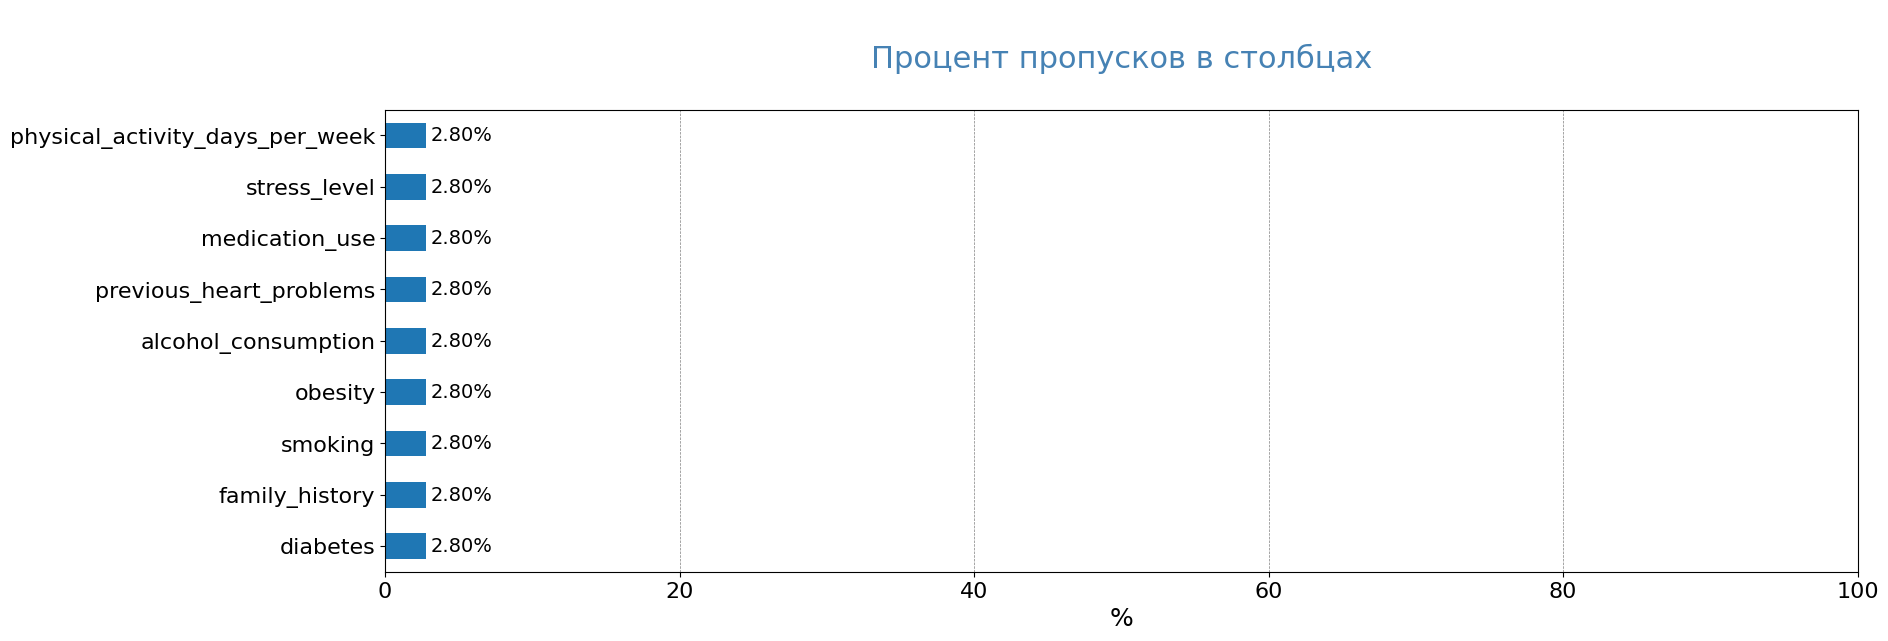

In [13]:
show_barh_with_indefinite_columns(heart_train);

В таблице присутствуют пропуски. Чтобы понять что с ними делать, их следует детально исследовать.

In [14]:
round(100 - heart_train.dropna()['id'].count() / heart_train['id'].count() * 100, 2)

np.float64(2.8)

Всего в таблице `2.8%` записей содержат пропуски.

#### 6.2.3 В таблице `heart_test`

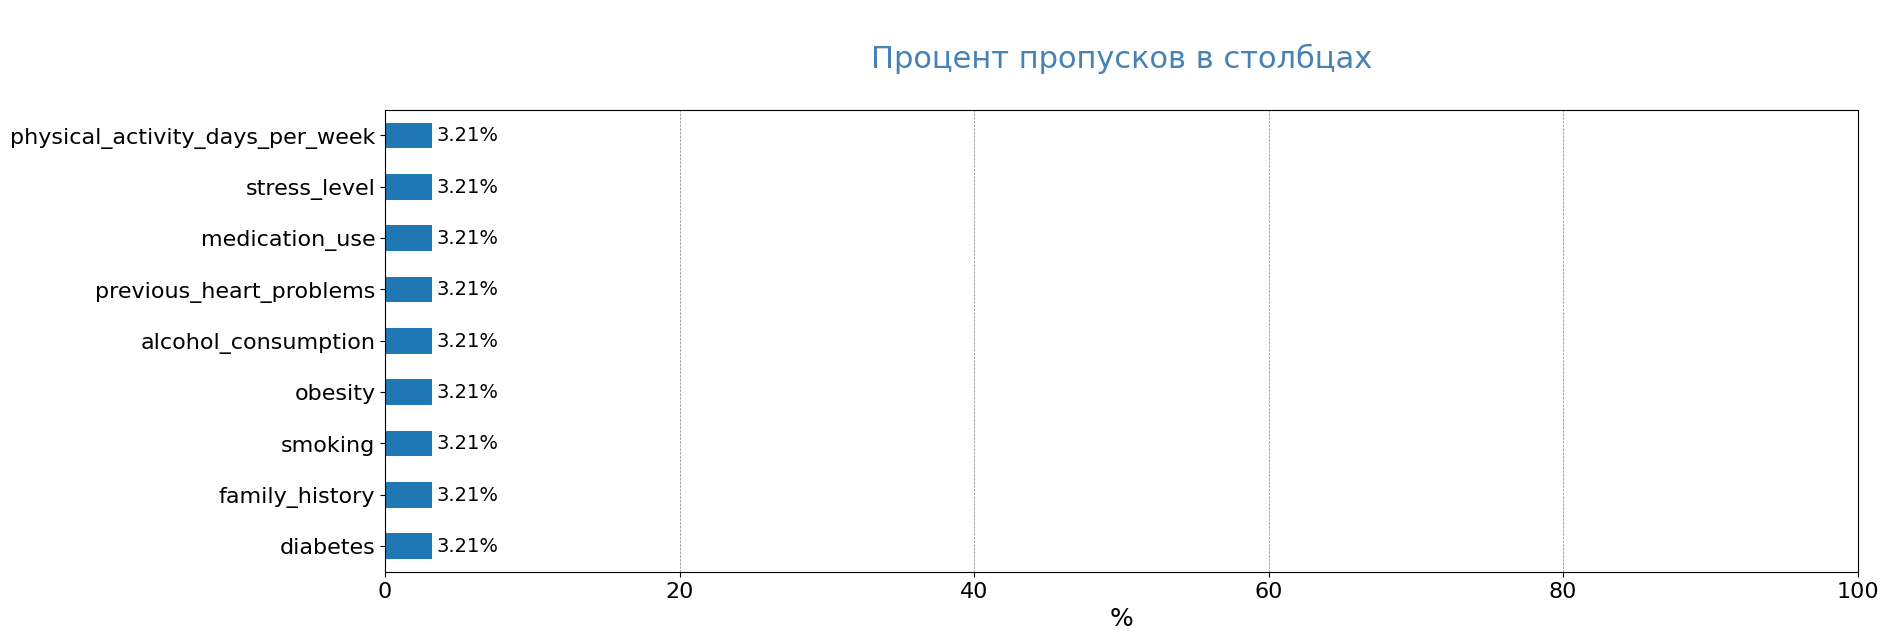

In [15]:
show_barh_with_indefinite_columns(heart_test);

В таблице присутствуют пропуски. Чтобы понять что с ними делать, их следует детально исследовать.

In [16]:
round(100 - heart_test.dropna()['id'].count() / heart_test['id'].count() * 100, 2)

np.float64(3.21)

Всего в таблице `3.21%` записей содержат пропуски.

### 6.3 Изучение дубликатов в таблицах

#### 6.3.1 Для таблицы  `heart_train`

Проверка явных дубликатов:

In [17]:
heart_train.duplicated().sum()

np.int64(0)

Явных дубликатов не обнаружено.

Проверка неявных дубликатов по признаку `id`:

In [18]:
heart_train.duplicated('id').sum()

np.int64(0)

Неявных дубликатов не обнаружено.

#### 6.3.2 Для таблицы  `df_test`

Проверка явных дубликатов:

In [19]:
heart_test.duplicated().sum()

np.int64(0)

Явных дубликатов не обнаружено.

Проверка неявных дубликатов по признаку `id`:

In [20]:
heart_test.duplicated('id').sum()

np.int64(0)

Неявных дубликатов не обнаружено.

### 6.4 Изучение категориальных значений

#### 6.4.1 Для таблицы  `heart_train`

##### 6.4.1.1 Признак `diabetes`

In [21]:
heart_train['diabetes'].unique()

array([ 1.,  0., nan])

In [22]:
heart_train[heart_train['gender'] == '1.0']['blood_sugar'].sum()

np.float64(31.90316205533597)

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.2 Признак `family_history`

In [23]:
heart_train['family_history'].unique()

array([ 1.,  0., nan])

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.3 Признак `smoking`

In [24]:
heart_train['smoking'].unique()

array([ 1.,  0., nan])

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.4 Признак `obesity`

In [25]:
heart_train['obesity'].unique()

array([ 1.,  0., nan])

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.5 Признак `alcohol_consumption`

In [26]:
heart_train['alcohol_consumption'].unique()

array([ 1.,  0., nan])

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.6 Признак `previous_heart_problems`

In [27]:
heart_train['previous_heart_problems'].unique()

array([ 1.,  0., nan])

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.7 Признак `medication_use`

In [28]:
heart_train['medication_use'].unique()

array([ 0.,  1., nan])

Признак содержит всего 2 уникальных значения и пропуск, дополнительные преобразования не требуются.

##### 6.4.1.8 Признак `diet`

In [29]:
heart_train['diet'].unique()

array([1, 2, 0, 3])

Признак содержит всего 4 уникальных значения, дополнительные преобразования не требуются.

##### 6.4.1.9 Признак `gender`

In [30]:
heart_train['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

Признак содержит всего 4 уникальных значения, принято представителей мужского пола обозначать `1`, а женского `0`.

In [31]:
heart_train['gender'] = (
    heart_train['gender']
        .replace({ 'Male': '1.0', 'Female': '0.0' })
        .astype('float')
        .astype('int')
)

In [32]:
heart_train['gender'].unique()

array([1, 0])

Теперь признак содержит всего 2 уникальных значения, дополнительные преобразования не требуются.

##### 6.4.1.10 Признак `target`

In [33]:
heart_train['target'].unique()

array([0., 1.])

Признак содержит всего 2 уникальных значения, дополнительные преобразования не требуются.

#### 6.4.2 Для таблицы  `heart_test`

##### 6.4.2.1 Признак `diabetes`

In [34]:
heart_test['diabetes'].unique()

array([ 0.,  1., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.2 Признак `family_history`

In [35]:
heart_test['family_history'].unique()

array([ 1.,  0., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.3 Признак `smoking`

In [36]:
heart_test['smoking'].unique()

array([ 1.,  0., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.4 Признак `obesity`

In [37]:
heart_test['obesity'].unique()

array([ 1.,  0., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.5 Признак `alcohol_consumption`

In [38]:
heart_test['alcohol_consumption'].unique()

array([ 1.,  0., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.6 Признак `previous_heart_problems`

In [39]:
heart_test['previous_heart_problems'].unique()

array([ 0.,  1., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.7 Признак `medication_use`

In [40]:
heart_test['medication_use'].unique()

array([ 0.,  1., nan])

Признак содержит всего 3 уникальных значения один из которых пропуск, дополнительные преобразования могут потребоваться после исследования.

##### 6.4.2.8 Признак `diet`

Проверка признака `diet` на уникальные значения:

In [41]:
heart_test['diet'].unique()

array([2, 0, 1, 3])

Признак содержит всего 4 уникальных значения, поэтому дополнительные преобразования не требуются.

##### 6.4.2.9 Признак `gender`

In [42]:
heart_test['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

Признак содержит всего 4 уникальных значения, принято представителей мужского пола обозначать `1`, а женского `0`.

In [43]:
heart_test['gender'] = (
    heart_test['gender']
        .replace({ 'Male': '1.0', 'Female': '0.0' })
        .astype('float')
        .astype('int')
)

In [44]:
heart_test['gender'].unique()

array([1, 0])

Теперь признак содержит всего 2 уникальных значения, дополнительные преобразования не требуются.

## 6.5 Переиндексация таблиц

Так как `id` является уникальным значением можно осуществить переиндексацию строк в DF на основе этих `id`.

In [45]:
heart_train.set_index('id');

In [46]:
heart_test.set_index('id');

## 6.6 Вывод

В результате предобработки данных выявлено следующее:

- данные отмасштабированы, вероятнее всего использовался `MinMaxScaler`, так как значения располагаются в диапазоне от `0` до `1`, для более качественного анализа будет полезно знать минимальное и максимальное значение каждого признака.
- было произведено преобразование бинарных признаков к логическому типу.
- к признаку `diet` было применено кодирование вероятно это `OrderEncoder` или что-то похожее по смыслу на него.
- нужно исправить масштабирование признаков для некоторых моделей, которые критичны к масштабу, к таким признакам относятся:
    - `stress_level`;
    - `physical_activity_days_per_week`.
- в исходном виде тиблица `df_train` содержит `8685` записей из которых полностью заполнены только `8442` и неполные `243` записи.
- в исходном виде тиблица `df_test` содержит `966` записей из которых полностью заполнены только `935`, неполные `31` записи.
- Признаки не содержат дубликатов.

## 7 Исследовательский анализ данных

### 7.1 Объявление вспомогательных функций

In [47]:
def calculate_rows_and_cols(count, max_elements_in_row):
    if count == 0:
        return (0, 0)
    
    row_count = math.ceil(count / max_elements_in_row)
    col_count = max_elements_in_row if count >= max_elements_in_row else count

    return (row_count, col_count)

In [48]:
def calculate_rows_and_cols_indexes(index, max_elements_in_row):    
    row_index = index // max_elements_in_row
    col_index = index % max_elements_in_row
    
    return (row_index, col_index)

In [49]:
def show_boxplots_for_cols(df, col_names, max_elements_in_row=6, figsize=(12, 5)):
    count = len(col_names)
    if count == 0:
        return

    row_count, col_count = calculate_rows_and_cols(count, max_elements_in_row)
    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=figsize)

    # Приведение axes к массиву массивов для единообразного обращения
    if row_count == 1 and col_count == 1:
        axes = [[axes]]
    elif row_count == 1:
        axes = [axes]
    elif col_count == 1:
        axes = [[ax] for ax in axes]

    for index, col_name in enumerate(col_names):
        row_index, col_index = calculate_rows_and_cols_indexes(index, max_elements_in_row)
        ax = axes[row_index][col_index]
        sns.boxplot(data=df, x=col_name, ax=ax)
        ax.set_title(col_name)

    # Удаление пустых графиков, если есть
    for idx in range(count, row_count * col_count):
        row_index, col_index = calculate_rows_and_cols_indexes(idx, max_elements_in_row)
        axes[row_index][col_index].set_visible(False)

    plt.tight_layout()
    plt.show()

In [50]:
def show_histplots_for_cols(df, col_names, max_elements_in_row=3, range_map={}, bins_map={}, figsize=(12, 10)):
    count = len(col_names)
    if count == 0:
        return

    row_count, col_count = calculate_rows_and_cols(count, max_elements_in_row)
    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=figsize)

    # Приведение axes к виду массива массивов для единообразного обращения
    if row_count == 1 and col_count == 1:
        axes = [[axes]]
    elif row_count == 1:
        axes = [axes]
    elif col_count == 1:
        axes = [[ax] for ax in axes]

    for index, col_name in enumerate(col_names):
        row_index, col_index = calculate_rows_and_cols_indexes(index, max_elements_in_row)
        ax = axes[row_index][col_index]

        sns.histplot(
            data=df,
            x=col_name,
            ax=ax,
            bins=bins_map.get(col_name, 'auto'),
            binrange=range_map.get(col_name, None)
        )
        ax.set_title(col_name)

    # Удаление пустых графиков, если есть
    for idx in range(count, row_count * col_count):
        row_index, col_index = calculate_rows_and_cols_indexes(idx, max_elements_in_row)
        axes[row_index][col_index].set_visible(False)

    plt.tight_layout()
    plt.show()


In [51]:
def show_countplot_for_cols(df, col_names, max_elements_in_row=2, figsize=(12, 5)):
    count = len(col_names)
    if count == 0:
        return

    row_count, col_count = calculate_rows_and_cols(count, max_elements_in_row)
    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=figsize)

    # Приведение axes к виду массива массивов для единообразного обращения
    if row_count == 1 and col_count == 1:
        axes = [[axes]]
    elif row_count == 1:
        axes = [axes]
    elif col_count == 1:
        axes = [[ax] for ax in axes]

    for index, col_name in enumerate(col_names):
        row_index, col_index = calculate_rows_and_cols_indexes(index, max_elements_in_row)
        ax = axes[row_index][col_index]

        # если колонка float, то округляем до 2 знаков
        if df[col_name].dtype.kind in "f":
            data = df.assign(**{col_name: df[col_name].round(2)})
        else:
            data = df

        sns.countplot(
            data=data,
            x=col_name,
            ax=ax,
        )
        ax.set_title(col_name)

    # Удаление пустых графиков, если есть
    for idx in range(count, row_count * col_count):
        row_index, col_index = calculate_rows_and_cols_indexes(idx, max_elements_in_row)
        axes[row_index][col_index].set_visible(False)

    plt.tight_layout()
    plt.show()


In [52]:
def show_pie_for_cols(df, col_names, max_elements_in_row = 6, figsize=(4, 3)):
    count = len(col_names)
    row_count, col_count = calculate_rows_and_cols(count, max_elements_in_row);
    
    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=figsize)
    
    for index, col_name in enumerate(col_names):
        row_index, col_index = calculate_rows_and_cols_indexes(index, max_elements_in_row)        
        df[col_name].value_counts().plot(
            kind='pie',
            figsize=figsize,
            legend=True,
            autopct='%1.1f%%',
            labels=None,
            ax=axes[row_index, col_index],
        )
        axes[row_index, col_index].set_title(col_name)
        axes[row_index, col_index].set_ylabel('', fontsize=12)
        
    # Удаление пустых графиков, если есть
    for idx in range(count, row_count * col_count):
        row_index, col_index = calculate_rows_and_cols_indexes(idx, max_elements_in_row)
        axes[row_index][col_index].set_visible(False)
        
    plt.tight_layout()
    plt.show()

In [53]:
def show_hist_for_categories(
    df,
    col_name,
    category,
    bins='auto',
    figsize=(12, 5),
    range=None,
    ax=None,
    stat='count',
    common_norm=True,
    title='',
):
    category_list = df[category].unique()
    
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    for j, category_item in enumerate(category_list):
        sns.histplot(
            data=df[df[category] == category_item],
            x=col_name,
            ax=ax,
            bins=bins,
            binrange=range,
            alpha=0.5,
            label=category_item,
            stat=stat,
            common_norm=common_norm,
        )
        ax.set_title(title)
    ax.legend(title=category)

In [54]:
def show_hist_list_for_fields(
    df,
    target,
    fields,
    figsize=(12, 4),
    range_map={},
    bins_map={},
    stat='density',
    common_norm=False,
    max_elements_in_row=2,
):
    # Приведение fields к списку, если это не список
    if not isinstance(fields, (list, tuple)):
        field_list = [fields]
    else:
        field_list = fields

    count = len(field_list)
    row_count, col_count = calculate_rows_and_cols(count, max_elements_in_row);

    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(figsize[0], figsize[1] * row_count))
    
    # Приведение axes к виду массива массивов для единообразного обращения
    if row_count == 1 and col_count == 1:
        axes = [[axes]]
    elif row_count == 1:
        axes = [axes]
    elif col_count == 1:
        axes = [[ax] for ax in axes]

    for index, field in enumerate(field_list):
        row_index, col_index = calculate_rows_and_cols_indexes(index, max_elements_in_row)
        ax = axes[row_index][col_index]
        show_hist_for_categories(
            df=df,
            col_name=field,
            category=target,
            bins=bins_map.get(field, 'auto'),
            range=range_map.get(field, None),
            figsize=figsize,
            ax=ax,
            stat=stat,
            common_norm=False
        )
        ax.set_title(f"{target} | {field}")
    
    for idx in range(count, row_count * col_count):
        row_index, col_index = calculate_rows_and_cols_indexes(idx, max_elements_in_row)
        axes[row_index][col_index].set_visible(False)
    
    plt.tight_layout()
    plt.show()

### 7.2 Изучение непрерывных числовых признаков и дискретных признаков широкого диапазона значений.

Определение числовых признаков:

In [55]:
cont_cols = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'ck_mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
]

#### 7.2.1 Для таблицы `heart_train` до исключения пропусков

Основные статистики:

In [56]:
heart_train.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,target,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,...,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,...,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.695222,0.450295,0.497634,4831.210823
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,...,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.460340,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,...,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.000000,0.303226,0.348837,2425.000000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,...,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,1.000000,0.445161,0.500000,4837.000000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,...,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,1.000000,0.600000,0.651163,7242.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,...,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


Диаграммы размаха:

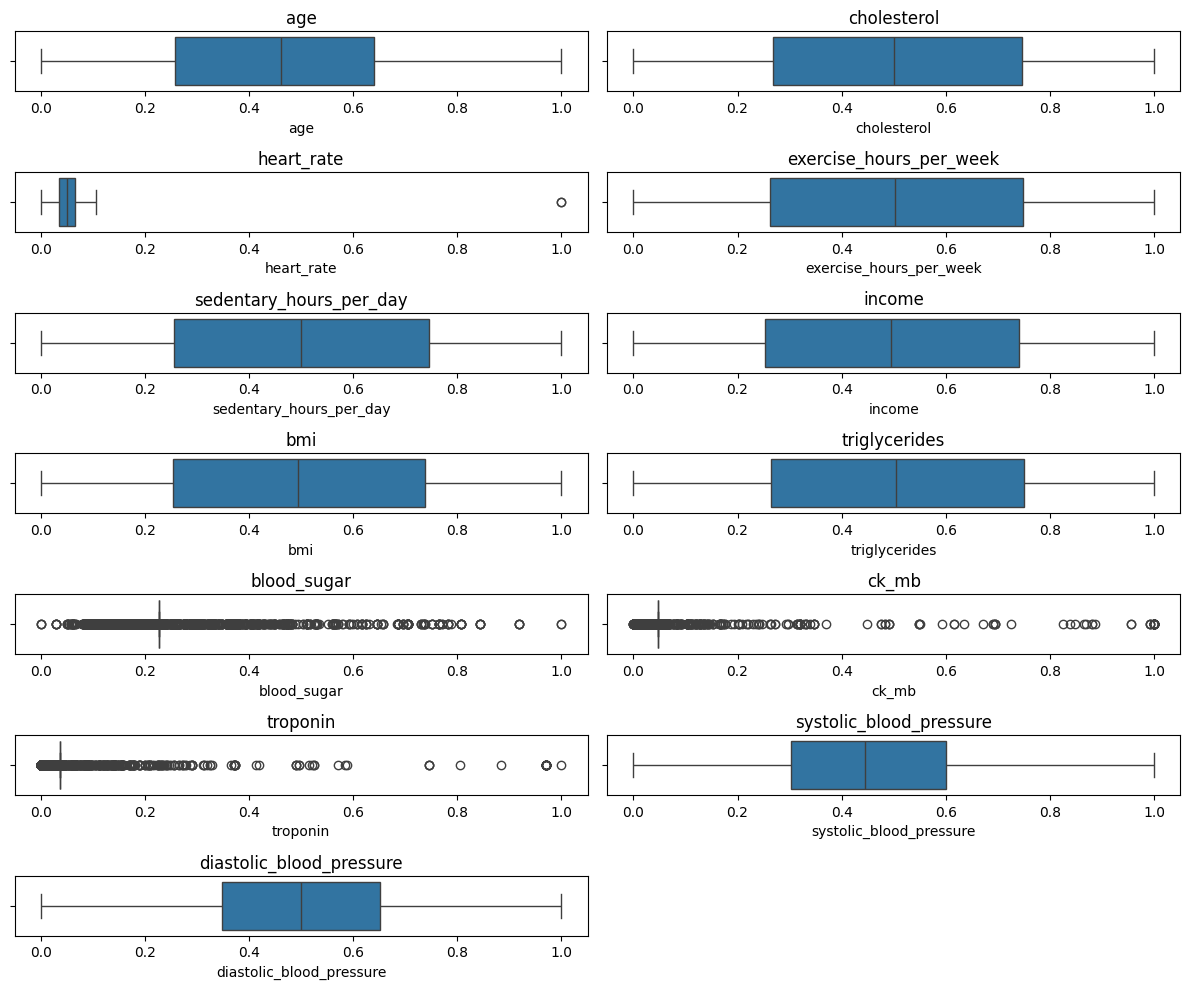

In [57]:
show_boxplots_for_cols(
    df=heart_train,
    col_names=cont_cols,
    max_elements_in_row=2,
    figsize=(12, 10),
)

Гистограммы:

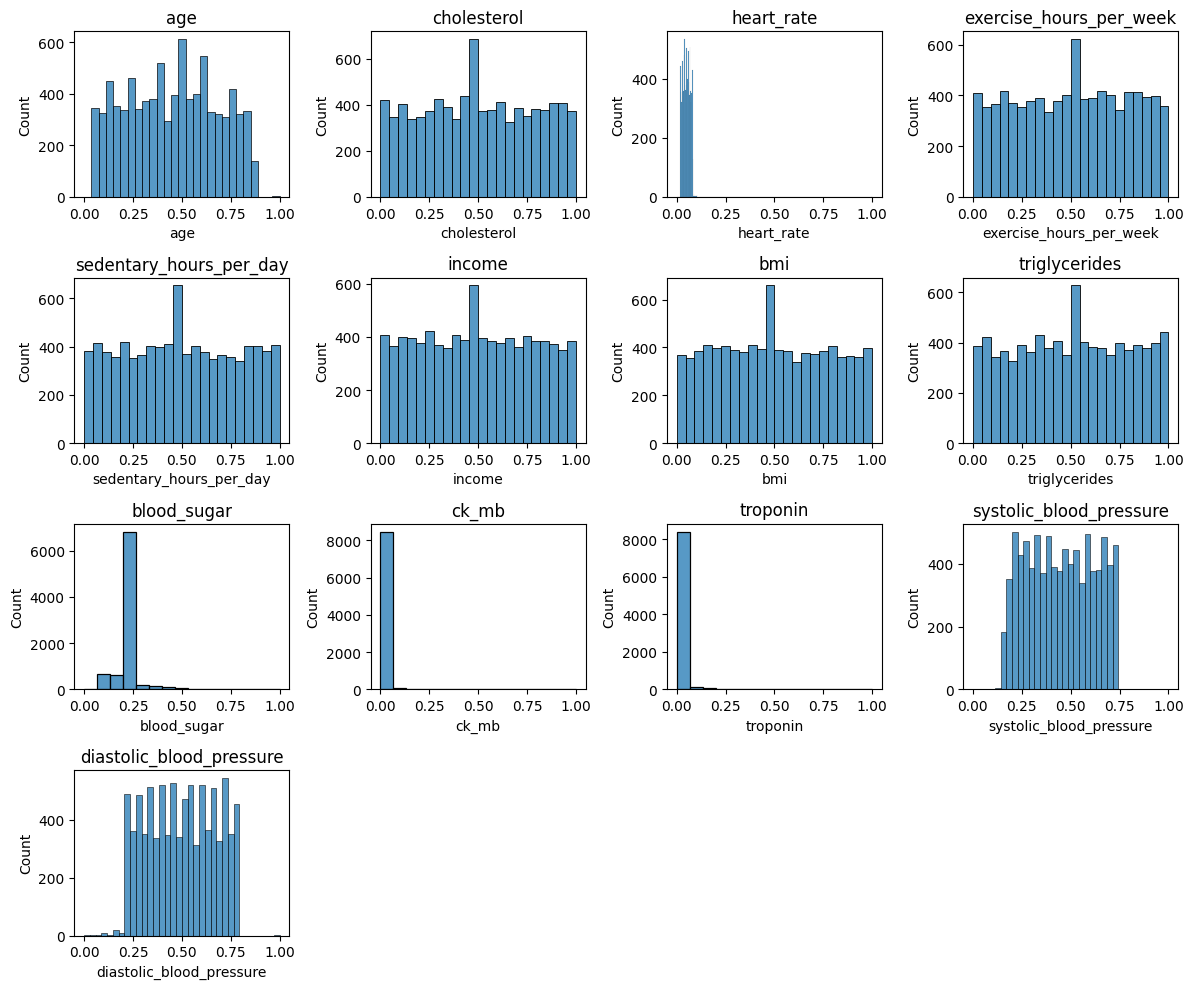

In [58]:
show_histplots_for_cols(
    df=heart_train,
    col_names=cont_cols,
    max_elements_in_row=4,
    figsize=(12, 10)
)

Судя по гистограммах и по диаграммам межквартильного размаха:

- У признаков `age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `systolic_blood_pressure`, `diastolic_blood_pressure` распределение выглядит относительно равномерным. Это говорит о том что данные достаточно разнообразны и после применения `MinMaxScaler` распределение растянулось по всему диапазону, однако наличие отдельных пиков в середине/медиане шкалы может указывать на то, что пропуски заменялись средними/медианными значениями. Следует дополнительно исследовать записи с пропусками, чтобы быть в этом уверенным.

- У признаков `blood_sugar`, `ck_mb` и `troponin` большинство значений расположены вблизи минимума и только небольшая часть тянется к верхнему краю диапазона (к `1`). Это также выражается в виде выбросов в boxplot-ах. Вероятно это проявления особых клинических состояний у пациентов. Стоит обратить на эти признаки особое внимание при дальнейшем анализе. У признака `blood_sugar` большинство значений сжаты ближе к нижней границе (около `0.2`), вероятно, в DataFrame  много пациентов с нормальным уровнем сахара и относительно мало с аномально высоким. У признаков `ck_mb` и `troponin` почти все значения находятся у минимума, лишь редкие - ближе к `1`.

- В большинстве признаков распределение выглядит как не очень качественно подготовленные для обучения моделей, наличие «искусственных пиков» требует дополнительной проверки.

- Для корректного анализа стоит отдельно проверить записи с пропусками, возможно именно они влияют на наличие пиковых значений на гистограммах.

#### 7.2.2 Для записей в таблице `heart_train` с пропусками

In [59]:
heart_train_with_na = heart_train[heart_train['smoking'].isna()]

Основные статистики:

In [60]:
heart_train_with_na['gender'].sum()

np.int64(156)

In [61]:
heart_train_with_na.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,target,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
count,243.000000,243.00000,243.000000,0.0,0.0,0.0,0.0,0.0,243.00000,243.0,...,0.0,2.430000e+02,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,0.482961,0.49978,0.066760,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,NaN,5.046212e-01,0.0,0.204436,0.062550,0.030492,0.641975,0.392646,0.357355,9514.913580
std,0.161522,0.00000,0.087221,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,...,NaN,1.112515e-16,0.0,0.126380,0.177867,0.085016,0.480409,0.160063,0.165995,79.212998
min,0.000000,0.49978,0.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,NaN,5.046212e-01,0.0,0.029644,0.000107,0.000194,0.000000,0.000000,0.000000,9377.000000
25%,0.370787,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,NaN,5.046212e-01,0.0,0.120553,0.004418,0.000485,0.000000,0.283871,0.232558,9445.500000
50%,0.516854,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,NaN,5.046212e-01,0.0,0.156126,0.008673,0.001262,1.000000,0.354839,0.360465,9516.000000
75%,0.578652,0.49978,0.069661,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,NaN,5.046212e-01,0.0,0.246047,0.021770,0.006311,1.000000,0.480645,0.453488,9583.500000
max,1.000000,0.49978,1.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,NaN,5.046212e-01,0.0,0.788538,1.000000,0.805806,1.000000,1.000000,1.000000,9650.000000


Диаграммы размаха:

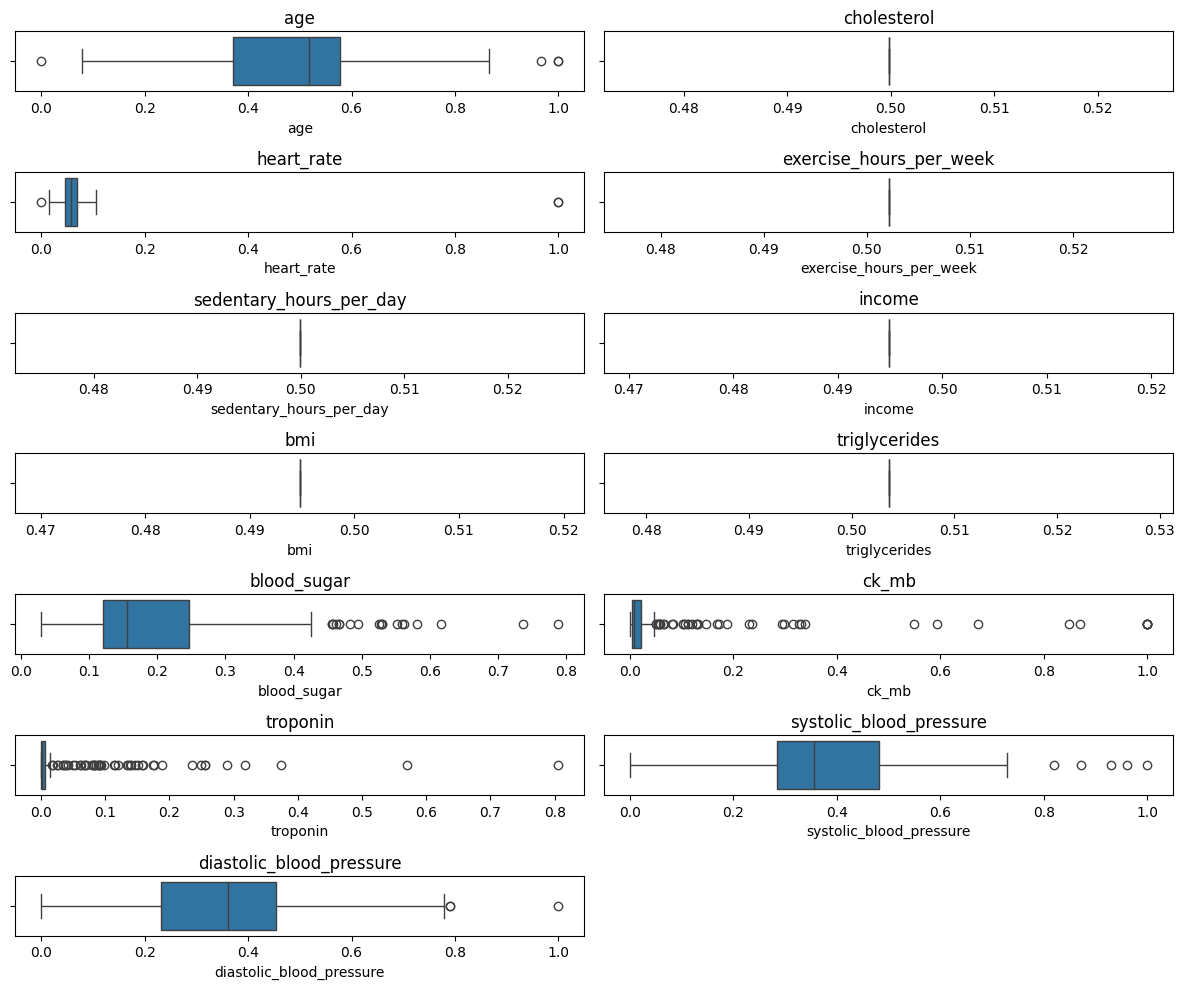

In [62]:
show_boxplots_for_cols(
    df=heart_train_with_na,
    col_names=cont_cols,
    max_elements_in_row=2,
    figsize=(12, 10),
)

Гистограммы:

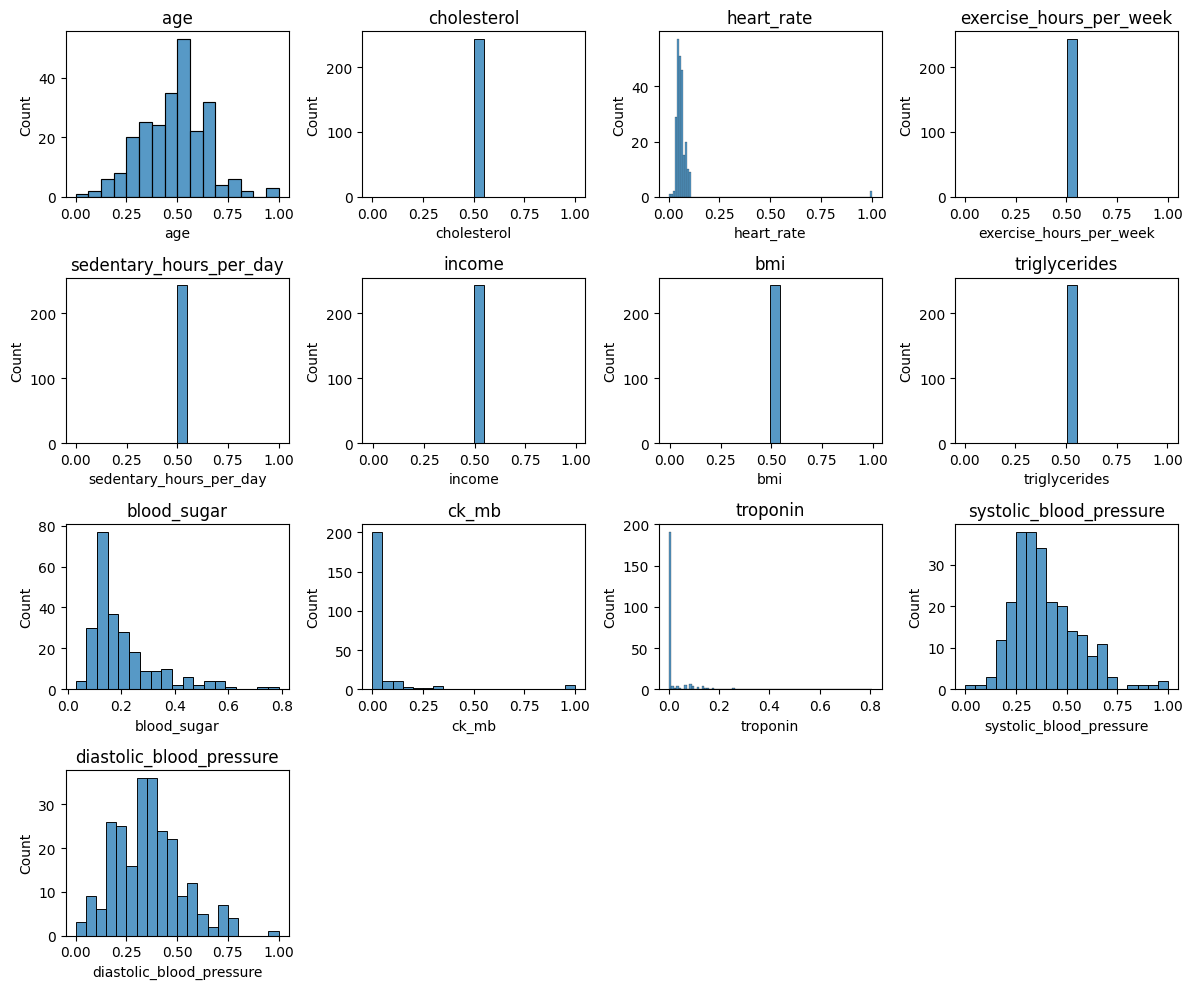

In [63]:
show_histplots_for_cols(
    df=heart_train_with_na,
    col_names=cont_cols,
    max_elements_in_row=4,
    figsize=(12, 10),
    bins_map={
        'cholesterol': 20,
        'heart_rate': 100,
        'exercise_hours_per_week': 20,
        'sedentary_hours_per_day': 20,
        'income': 20,
        'bmi': 20,
        'triglycerides': 20,
        'ck_mb': 20,
        'troponin': 80,
        'systolic_blood_pressure': 20,
        'diastolic_blood_pressure': 20,
    },
)

- У признаков `cholesterol`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides` распределение сосредоточено почти в одной точке, что выглядит подозрительно. Такое поведение указывает на возможное заполнение пропусков средними или фиксированными значениями до нормализации. Эти признаки стоит проверить отдельно: либо в данных действительно почти все значения одинаковые, либо это следствие предобработки.

- У признаков `age`, `systolic_blood_pressure`, `diastolic_blood_pressure` распределение выглядит более реалистично: значения варьируются по всему диапазону, форма ближе к нормальному распределению, выбросы присутствуют, но не доминируют. Эти признаки, скорее всего, несут полезную информацию для анализа.

- У признаков `blood_sugar`, `ck_mb`, `troponin` распределение с правосторонней скошенностью: большинство значений сосредоточено вблизи нуля, но присутствуют редкие высокие значения. На диаграмме межквартильного размаха они отражаются в виде выбросов. Такое поведение может указывать на наличие небольшой группы пациентов с аномальными показателями.

- У признака `heart_rate` наблюдается очень узкое распределение с концентрацией значений в одном диапазоне и редкими выбросами.

- Довольно большое количество признаков содержит заглушки. Также для всех них значение целевого признака выглядит подозрительно, все значения равны 0. Вероятно, это пациенты, которые ещё не успели пройти обследования или данные о них могли быть введены неверно.

#### 7.2.3 Для таблицы `heart_train` после исключения пропусков

In [64]:
heart_train_without_na = heart_train.dropna()

Основные статистики:

In [65]:
heart_train_without_na.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,target,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
count,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,...,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000
mean,0.449008,0.501108,0.050194,0.652097,0.489576,0.902867,0.498342,0.601990,0.503415,1.001540,...,3.508292,0.503712,0.356906,0.227998,0.047745,0.036867,0.696754,0.451955,0.501672,4696.392087
std,0.232809,0.288785,0.018442,0.476333,0.499921,0.296157,0.500027,0.489517,0.288881,0.812981,...,2.281772,0.332749,0.479115,0.074623,0.070399,0.059284,0.459688,0.170187,0.170302,2704.773301
min,0.044944,0.000000,0.018332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161290,0.209302,1.000000
25%,0.247191,0.260714,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.253359,0.000000,...,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.000000,0.303226,0.348837,2359.250000
50%,0.460674,0.496429,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.508244,1.000000,...,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,1.000000,0.451613,0.500000,4694.500000
75%,0.640449,0.750000,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.754901,2.000000,...,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,1.000000,0.600000,0.651163,7030.750000
max,0.853933,1.000000,0.082493,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.741935,0.790698,9376.000000


Диаграммы размаха:

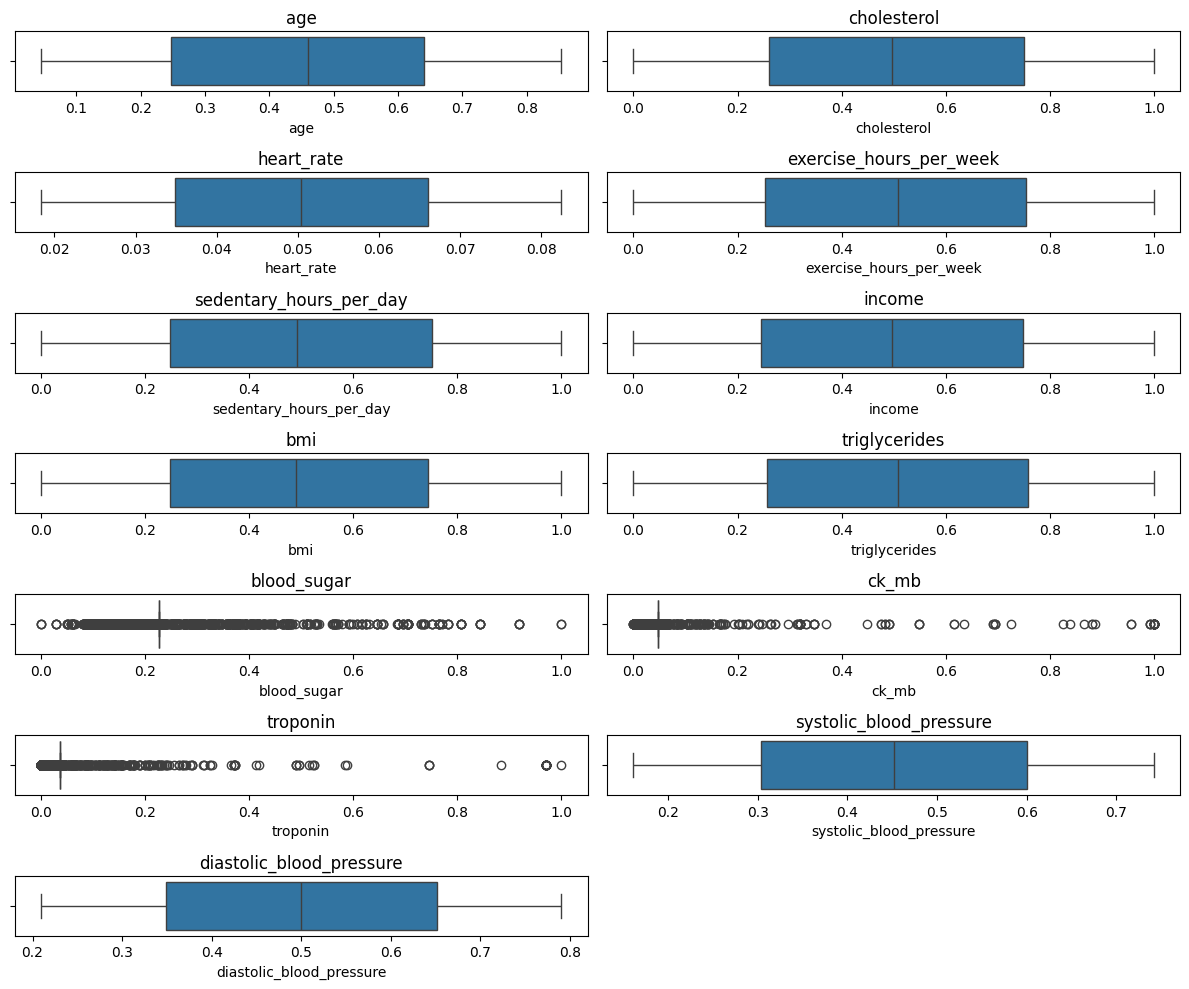

In [66]:
show_boxplots_for_cols(
    df=heart_train_without_na,
    col_names=cont_cols,
    max_elements_in_row=2,
    figsize=(12, 10),
)

Гистограммы:

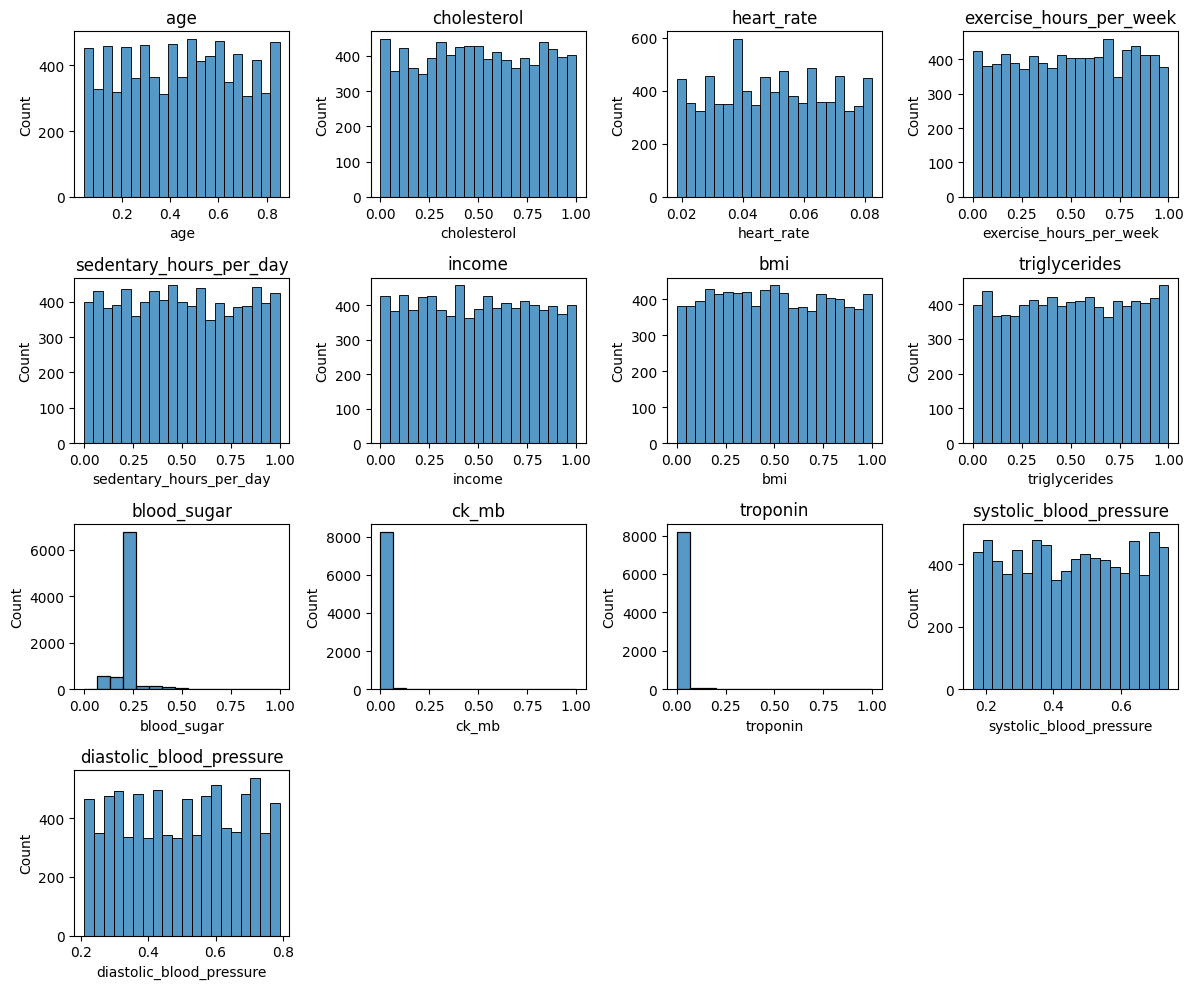

In [67]:
show_histplots_for_cols(
    df=heart_train_without_na,
    col_names=cont_cols,
    max_elements_in_row=4,
    figsize=(12, 10)
)

Судя по гистограммах и по диаграммам межквартильного размаха:

- У признаков `age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `systolic_blood_pressure`, `diastolic_blood_pressure` распределение выглядит относительно равномерным. Это говорит о том что данные достаточно разнообразны и после применения `MinMaxScaler` распределение растянулось по всему диапазону.

- У признаков `blood_sugar`, `ck_mb` и `troponin` большинство значений расположены вблизи минимума и только небольшая часть тянется к верхнему краю диапазона (к `1`). Это также выражается в виде выбросов в boxplot-ах. Вероятно это проявления особых клинических состояний у пациентов. Стоит обратить на эти признаки особое внимание при дальнейшем анализе. У признака `blood_sugar` большинство значений сжаты ближе к нижней границе (около `0.2`), вероятно, в DataFrame  много пациентов с нормальным уровнем сахара и относительно мало с аномально высоким. У признаков `ck_mb` и `troponin` почти все значения находятся у минимума, лишь редкие - ближе к `1`.

- Ранее данные содержали пропуски и в них присутствовавали значения для признаков `age`, `heart_rate`, `blood_sugar`, `systolic_blood_pressure` и `diastolic_blood_pressure`, которые расширили их диапазоны значений. При обучении для них нужно повторно применить `MinMaxScaler`, чтобы распределить влияние признаков на обучающую модель более равномерно.

#### 7.2.4 Для таблицы `heart_test` до исключения пропусков

Основные статистики:

In [68]:
heart_test.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
count,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,...,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,...,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.695652,0.447172,0.496822,4769.160455
std,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,...,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.460369,0.171837,0.173935,2818.815407
min,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,...,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.000000,0.012903,0.116279,0.000000
25%,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,...,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.000000,0.296774,0.348837,2275.750000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,...,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,1.000000,0.445161,0.488372,4769.500000
75%,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,...,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,1.000000,0.600000,0.639535,7206.000000
max,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,...,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,1.000000,0.741935,0.790698,9644.000000


Диаграммы размаха:

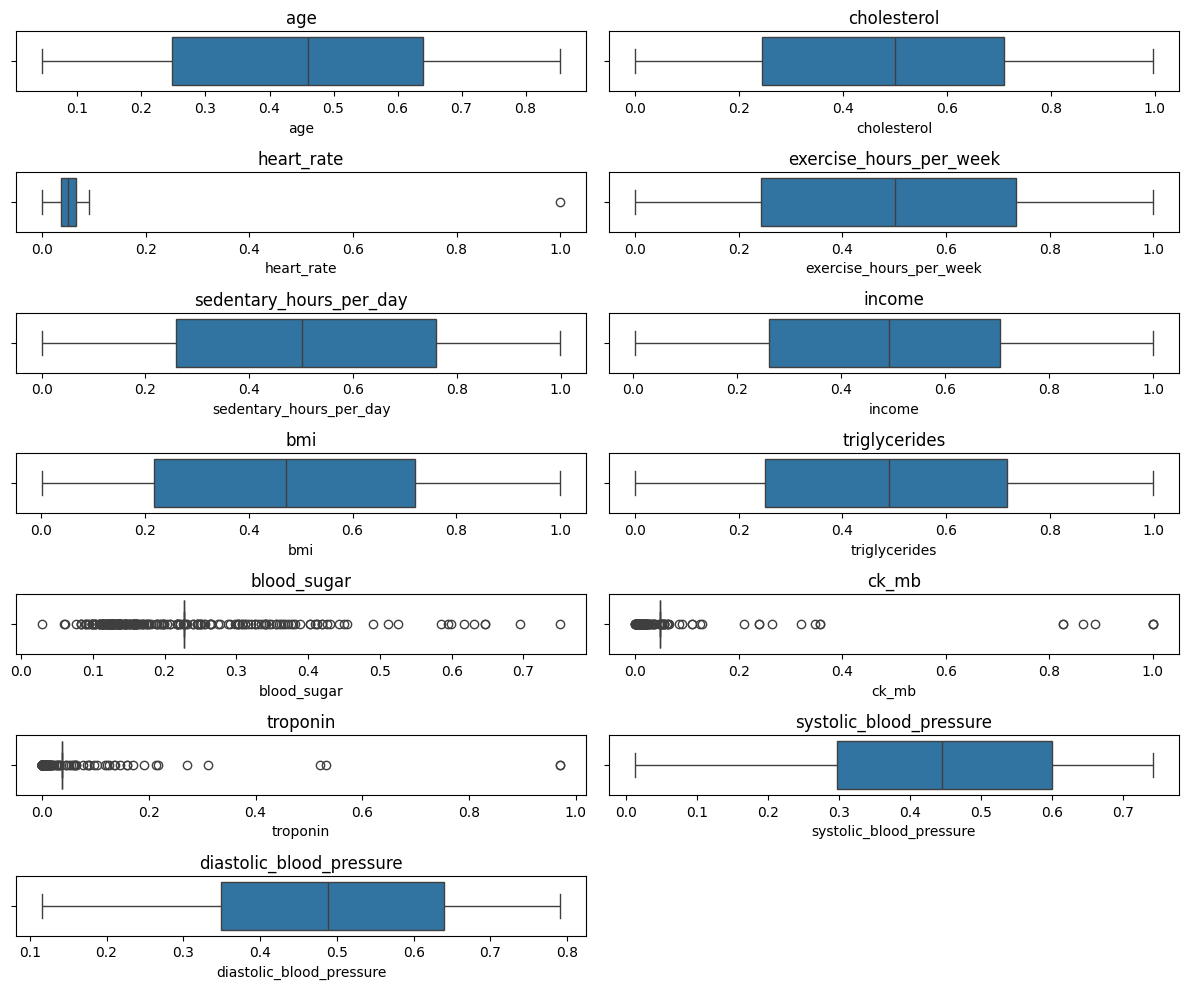

In [69]:
show_boxplots_for_cols(
    df=heart_test,
    col_names=cont_cols,
    max_elements_in_row=2,
    figsize=(12, 10),
)

Гистограммы:

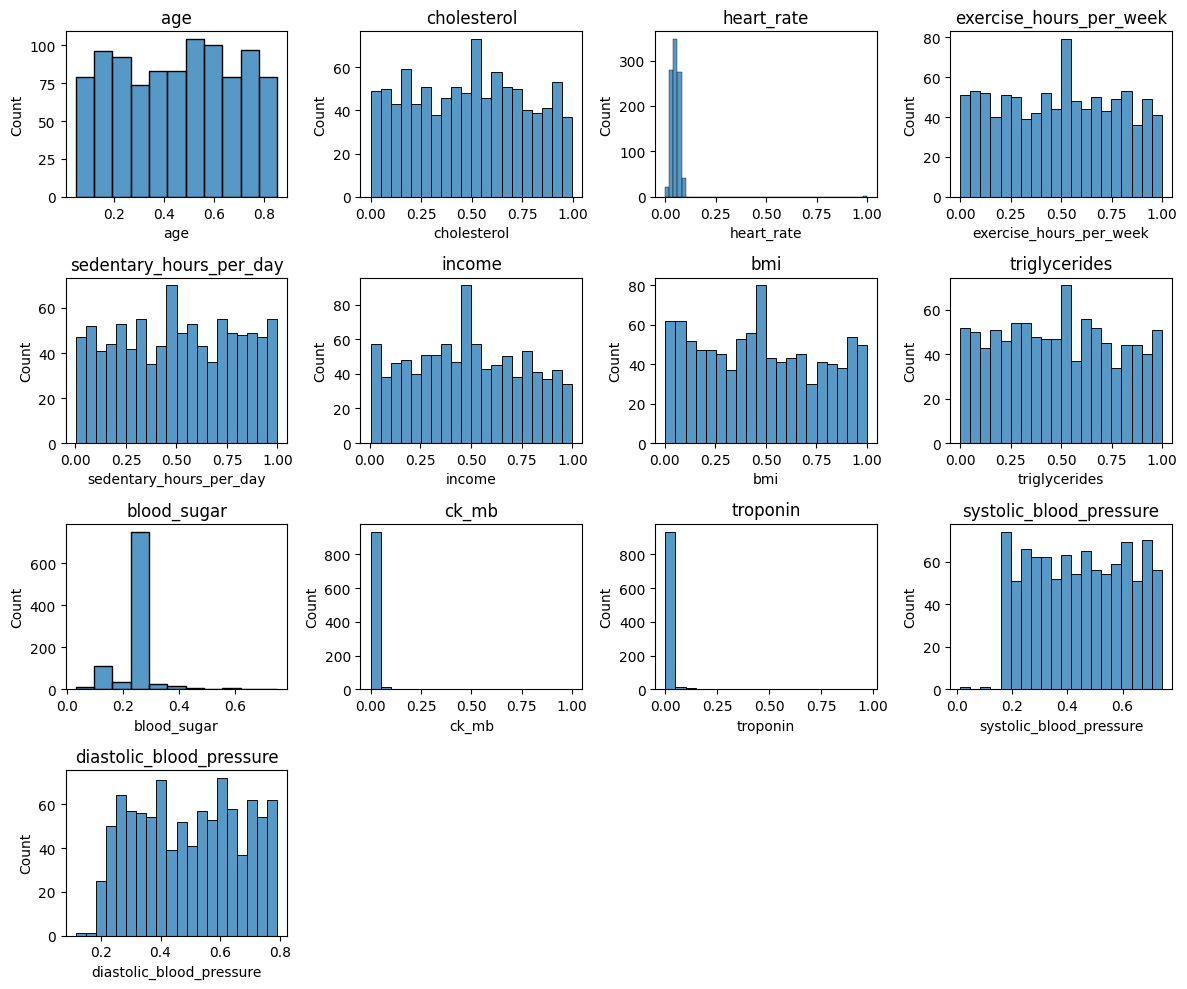

In [70]:
show_histplots_for_cols(
    df=heart_test,
    col_names=cont_cols,
    max_elements_in_row=4,
    figsize=(12, 10),
    bins_map={
        'cholesterol': 20,
        'heart_rate': 50,
        'exercise_hours_per_week': 20,
        'sedentary_hours_per_day': 20,
        'income': 20,
        'bmi': 20,
        'triglycerides': 20,
        'ck_mb': 20,
        'troponin': 20,
        'systolic_blood_pressure': 20,
        'diastolic_blood_pressure': 20,
    },
)

Судя по гистограммах и по диаграммам межквартильного размаха:

- У признаков `age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `systolic_blood_pressure`, `diastolic_blood_pressure` распределение выглядит относительно равномерным. Это говорит о том что данные достаточно разнообразны и после применения `MinMaxScaler` распределение растянулось по всему диапазону, однако наличие отдельных пиков в середине/медиане шкалы может указывать на то, что пропуски заменялись средними/медианными значениями. Следует дополнительно исследовать записи с пропусками, чтобы быть в этом уверенным.

- У признаков `blood_sugar`, `ck_mb` и `troponin` большинство значений расположены вблизи минимума и только небольшая часть тянется к верхнему краю диапазона (к `1`). Это также выражается в виде выбросов на диаграммах размаха. Вероятно, это проявления особых клинических состояний у пациентов. Стоит обратить на эти признаки особое внимание при дальнейшем анализе. У признака `blood_sugar` большинство значений сжаты ближе к нижней границе (около `0.25`), вероятно, в DataFrame  много пациентов с нормальным уровнем сахара и относительно мало с аномально высоким. У признаков `ck_mb` и `troponin` почти все значения находятся у минимума, лишь редкие - ближе к `1`.

- Для корректного анализа стоит отдельно проверить записи с пропусками, возможно именно они влияют на наличие пиковых значений на гистограммах.

#### 7.2.5 Для записей в таблице `heart_test` с пропусками

In [71]:
heart_test_with_na = heart_test[heart_test['smoking'].isna()]

Основные статистики:

In [72]:
heart_test_with_na.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
count,31.000000,3.100000e+01,31.000000,0.0,0.0,0.0,0.0,0.0,31.00000,31.0,...,3.100000e+01,0.0,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.477347,4.997802e-01,0.082404,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,5.036030e-01,NaN,5.046212e-01,0.171363,0.044163,0.040903,0.709677,0.370239,0.378095,9502.419355
std,0.118089,1.128575e-16,0.171493,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,...,1.128575e-16,NaN,1.128575e-16,0.086802,0.177802,0.174275,0.461414,0.152743,0.153261,79.883988
min,0.280899,4.997802e-01,0.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,5.036030e-01,NaN,5.046212e-01,0.061265,0.001548,0.000194,0.000000,0.012903,0.116279,9391.000000
25%,0.359551,4.997802e-01,0.038955,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,5.036030e-01,NaN,5.046212e-01,0.124506,0.006070,0.000583,0.000000,0.300000,0.296512,9444.500000
50%,0.483146,4.997802e-01,0.048579,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,5.036030e-01,NaN,5.046212e-01,0.144269,0.009740,0.001068,1.000000,0.380645,0.337209,9471.000000
75%,0.578652,4.997802e-01,0.063703,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,5.036030e-01,NaN,5.046212e-01,0.203557,0.014412,0.004612,1.000000,0.429032,0.476744,9566.500000
max,0.651685,4.997802e-01,1.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,...,5.036030e-01,NaN,5.046212e-01,0.490119,1.000000,0.970871,1.000000,0.722581,0.732558,9644.000000


Диаграммы размаха:

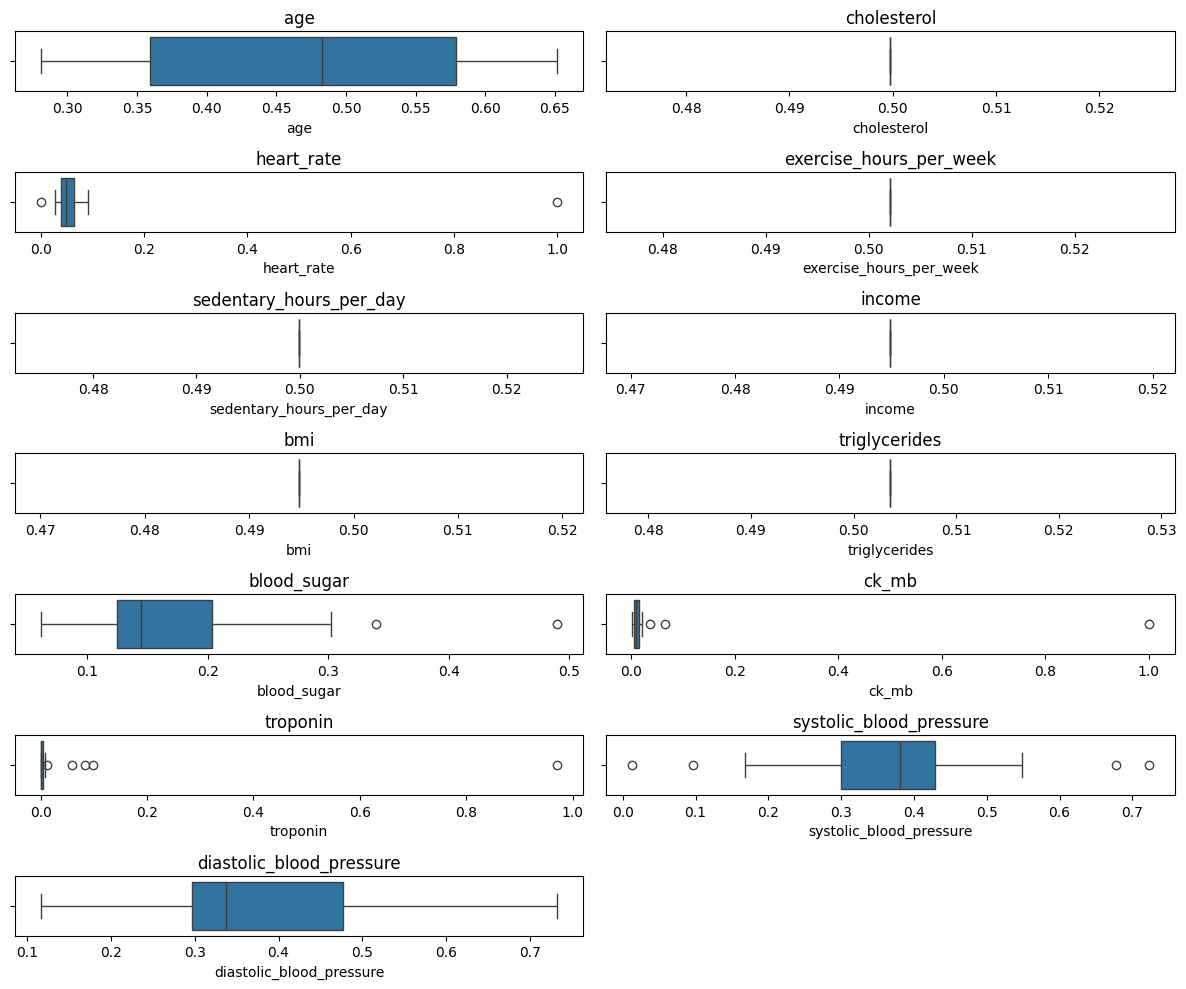

In [73]:
show_boxplots_for_cols(
    df=heart_test_with_na,
    col_names=cont_cols,
    max_elements_in_row=2,
    figsize=(12, 10),
)

Гистограммы:

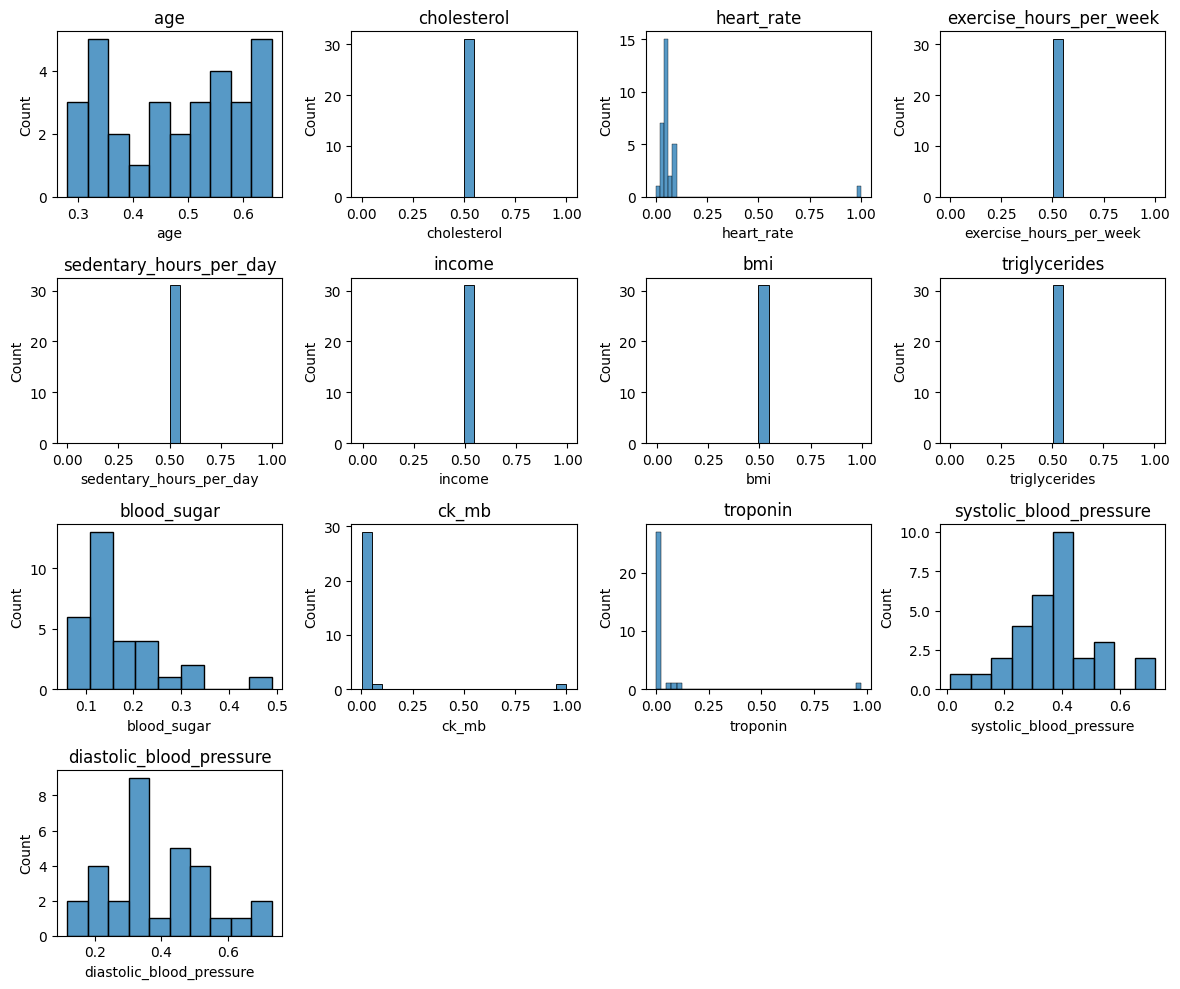

In [74]:
show_histplots_for_cols(
    df=heart_test_with_na,
    col_names=cont_cols,
    max_elements_in_row=4,
    figsize=(12, 10),
    bins_map={
        'age': 10,
        'cholesterol': 20,
        'heart_rate': 50,
        'exercise_hours_per_week': 20,
        'sedentary_hours_per_day': 20,
        'income': 20,
        'bmi': 20,
        'triglycerides': 20,
        'ck_mb': 20,
        'troponin': 40,
        'systolic_blood_pressure': 10,
        'diastolic_blood_pressure': 10,
    }
)

- У признака `heart_rate` наблюдается очень узкая концентрация значений в малом диапазоне и редкие выбросы далеко за его пределами. Такое распределение может быть следствием некорректной предобработки или особенностей исходных данных.

- У признаков `age`, `systolic_blood_pressure`, `diastolic_blood_pressure` распределение выглядит естественно: значения варьируются по диапазону, присутствуют выбросы, но в целом форма похожа на реальное распределение данных.

- У признаков `cholesterol`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides` распределение сосредоточено в одной точке, что выглядит искусственно. Это указывает на возможное заполнение пропусков средними значениями или другими заглушками до применения нормализации.

- У признаков `blood_sugar`, `ck_mb`, `troponin` распределение с правосторонней скошенностью: большинство значений находится у нижней границы, а редкие наблюдения тянутся к верхним значениям диапазона. Это также выражается в виде выбросов, что может отражать наличие небольшой группы пациентов с патологическими значениями.

#### 7.2.6 Для таблицы `heart_test` после исключения пропусков

In [75]:
heart_test_without_na = heart_test.dropna()

Основные статистики:

In [76]:
heart_test_without_na.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
count,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,...,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000
mean,0.452106,0.487796,0.050624,0.656684,0.481283,0.898396,0.516578,0.583957,0.490327,0.989305,...,0.486127,3.443850,0.512834,0.225876,0.049011,0.034728,0.695187,0.449722,0.500759,4612.228877
std,0.233873,0.286674,0.018031,0.475070,0.499917,0.302289,0.499993,0.493165,0.289584,0.823824,...,0.289200,2.302778,0.327594,0.063750,0.074523,0.044943,0.460574,0.171918,0.173262,2727.818068
min,0.044944,0.000000,0.018332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,...,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.000000,0.161290,0.209302,0.000000
25%,0.235955,0.235714,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.235647,0.000000,...,0.243506,1.000000,0.166667,0.227018,0.048229,0.036512,0.000000,0.296774,0.348837,2231.500000
50%,0.460674,0.485714,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.493305,1.000000,...,0.471429,3.000000,0.500000,0.227018,0.048229,0.036512,1.000000,0.458065,0.500000,4625.000000
75%,0.651685,0.723214,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.739898,2.000000,...,0.732468,5.000000,0.833333,0.227018,0.048229,0.036512,1.000000,0.600000,0.651163,7035.000000
max,0.853933,0.996429,0.082493,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,2.000000,...,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,1.000000,0.741935,0.790698,9362.000000


Диаграммы размаха:

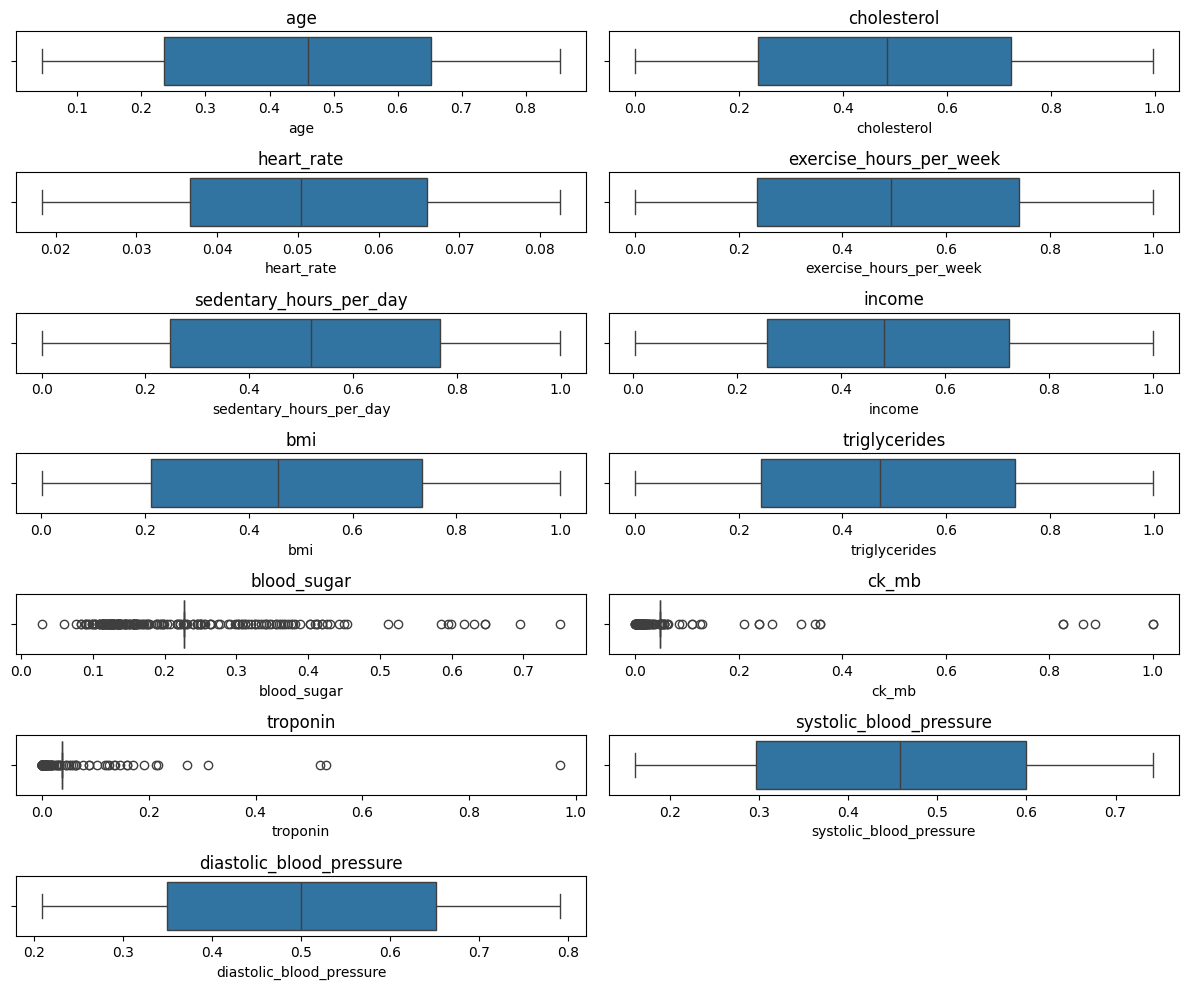

In [77]:
show_boxplots_for_cols(
    df=heart_test_without_na,
    col_names=cont_cols,
    max_elements_in_row=2,
    figsize=(12, 10),
)

Гистограммы:

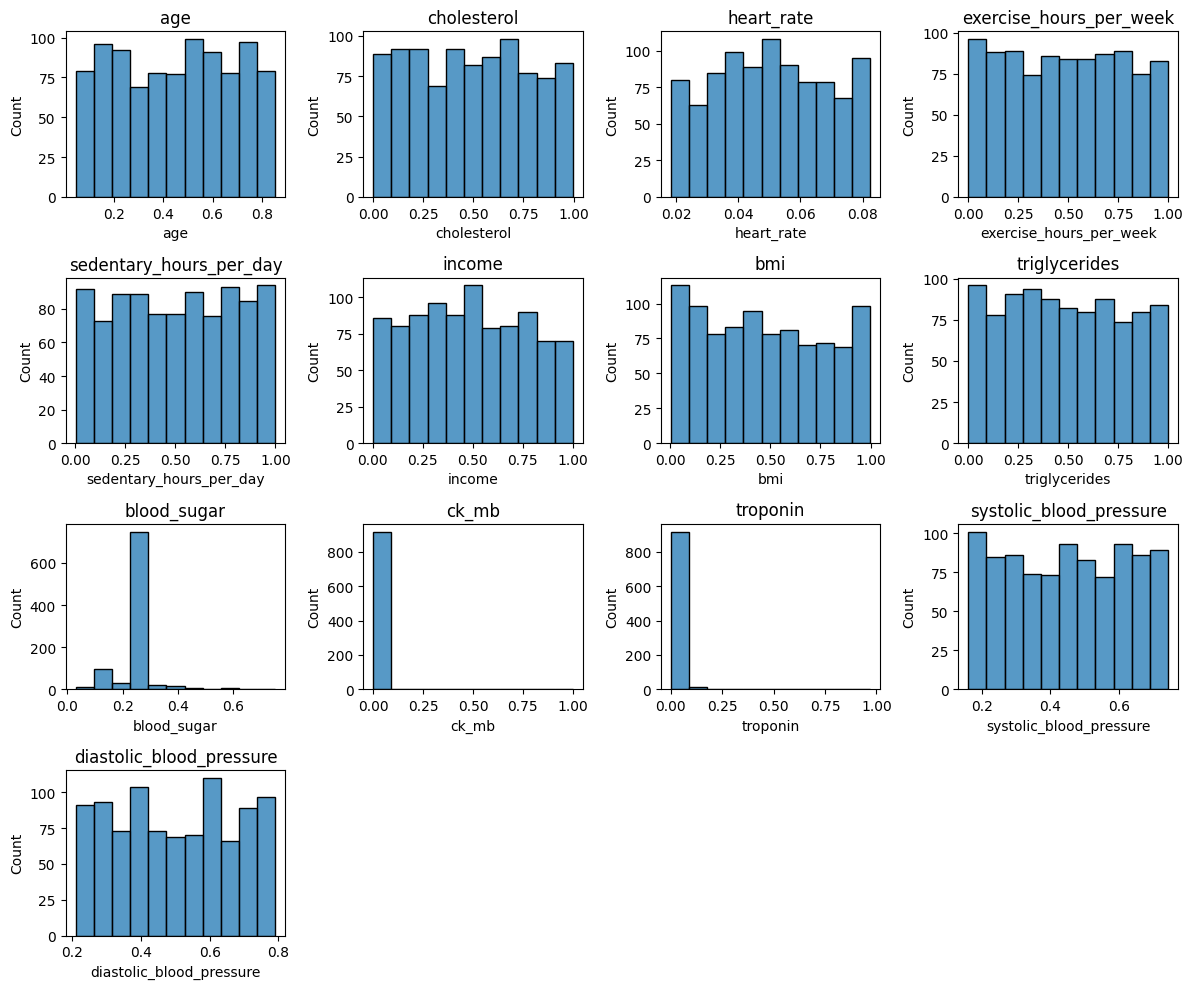

In [78]:
show_histplots_for_cols(
    df=heart_test_without_na,
    col_names=cont_cols,
    max_elements_in_row=4,
    figsize=(12, 10)
)

Судя по гистограммах и по диаграммам межквартильного размаха:

- У признаков `age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `systolic_blood_pressure`, `diastolic_blood_pressure` распределение выглядит относительно равномерным. Это говорит о том что данные достаточно разнообразны и после применения `MinMaxScaler` распределение растянулось по всему диапазону.

- У признаков `blood_sugar`, `ck_mb` и `troponin` большинство значений расположены вблизи минимума и только небольшая часть тянется к верхнему краю диапазона (к `1`). Это также выражается в виде выбросов в boxplot-ах. Вероятно это проявления особых клинических состояний у пациентов. Стоит обратить на эти признаки особое внимание при дальнейшем анализе. У признака `blood_sugar` большинство значений сжаты ближе к нижней границе (около `0.25`), вероятно, в DataFrame  много пациентов с нормальным уровнем сахара и относительно мало с аномально высоким. У признаков `ck_mb` и `troponin` почти все значения находятся у минимума, лишь редкие - ближе к `1`.

- Ранее данные содержали пропуски и в них присутствовавали значения для признаков `age`, `heart_rate`, `blood_sugar`, `systolic_blood_pressure` и `diastolic_blood_pressure`, которые расширили их диапазоны значений. При обучении для них нужно повторно применить `MinMaxScaler` по аналогии с обучающей выборкой.

### 7.3 Изучение дискретных числовых признаков

In [79]:
num_cols = [
    'stress_level',
    'physical_activity_days_per_week',
    'sleep_hours_per_day',
]

#### 7.3.1 Для таблицы `heart_train_without_na`

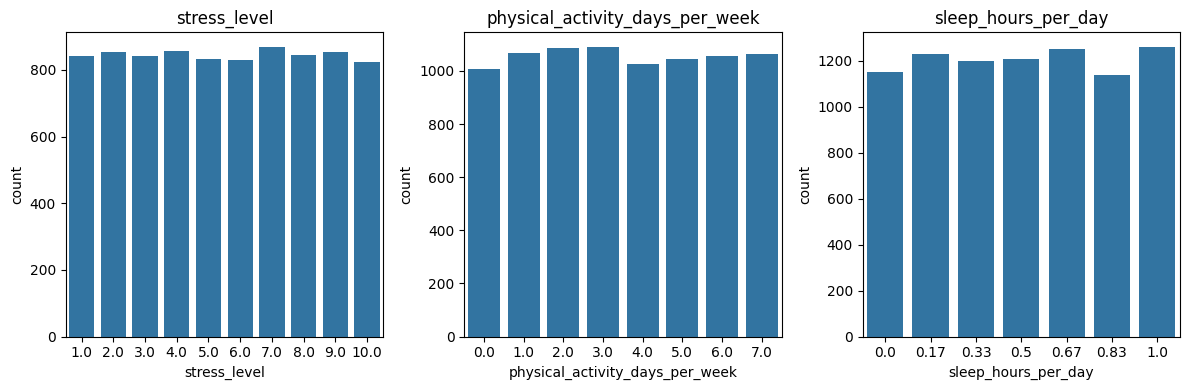

In [80]:
show_countplot_for_cols(
    df=heart_train_without_na,
    col_names=num_cols,
    max_elements_in_row=3,
    figsize=(12, 4),
)

- все три признака распределены равномерно.
- это может быть полезно для обучения модели, так как для неё будет одинаковое количество примеров для каждого значения благодаря чему она не будет предвзята к какому-то конкретному уровню.
- такое распределение может быть результатом искусственной генерации данных или балансировки.

#### 7.3.2 Для таблицы `heart_test_without_na`

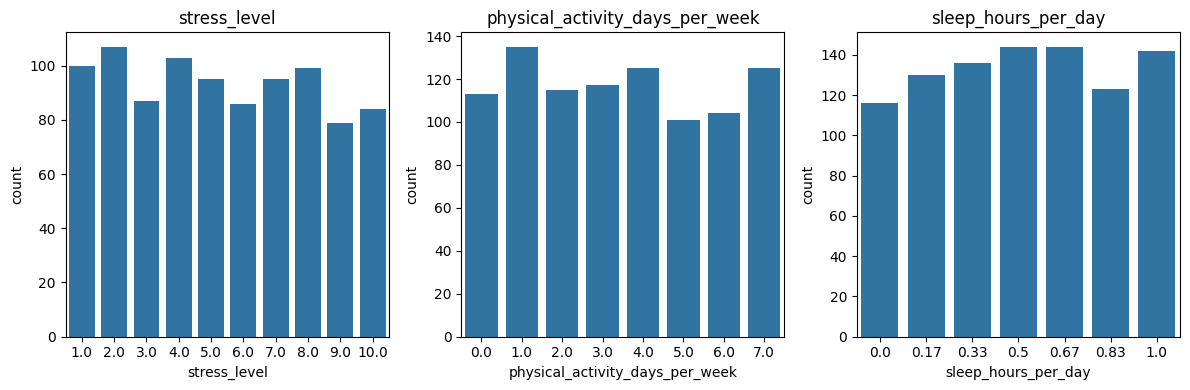

In [81]:
show_countplot_for_cols(
    df=heart_test_without_na,
    col_names=num_cols,
    max_elements_in_row=3,
    figsize=(12, 4),
)

Судя по диаграммам:
- `stress_level`:
    - значения распределены относительно равномерно в диапазоне от `1` до `10`, но есть пики на `2`, `4` и `8`.
    - это отражает, что часть людей чаще оценивает стресс как "ниже среднего" (`2`) или "выше среднего" (`8`)
- `physical_activity_days_per_week`:
    - почти равномерное распределение, но заметны небольшие пики на `1`, `4` и на `7`
    - это похоже на реальные данные, так как люди с высокой долей вероятности уделяют тренировкам не одинаковое количество дней в неделю.
- `sleep_hours_per_day`:
    - к значениям применен `MinMaxScaler`, поэтому они располагаются в диапазоне от `0` до `1`.
    - пик приходится на значения в диапазоне от `0.5` до `0.67`, также наблюдается пик на уровне `1`.

### 7.4 Изучение категориальных признаков

In [82]:
cat_cols = [
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'diet',
    'previous_heart_problems',
    'medication_use',
    'gender',
    'target',
]

In [83]:
df_train = heart_train_without_na

In [84]:
df_test = heart_test_without_na

#### 7.4.1 Для таблицы `df_train`

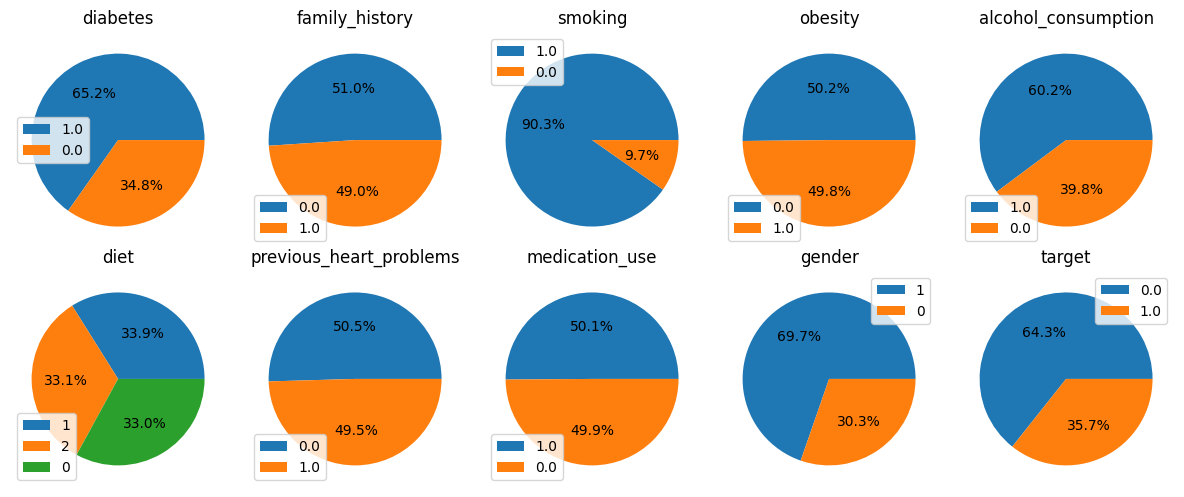

In [85]:
show_pie_for_cols(
    df=df_train,
    col_names=cat_cols,
    max_elements_in_row=5,
    figsize=(12, 5)
)

- Признаки `family_history`, `obesity`, `diet`, `previous_heart_problems`, `medication_use` - сбалансированы.
- Признаким `diabetes`, `alcohol_consumption`, `gender` являются признаками с умеренным дисбалансом.
- У признака `smoking` сильный дисбаланс.
- Распределения выглядят адекватными.
- Отсутствуют полностью пустые категории, классы представлены в достаточном объёме для анализа.

#### 7.4.2 Для таблицы `df_test`

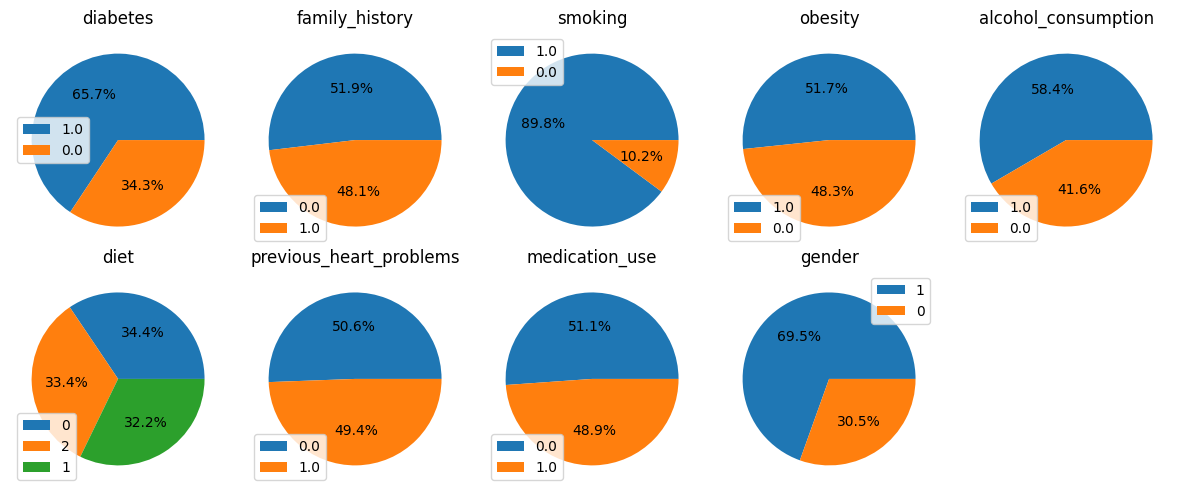

In [86]:
show_pie_for_cols(
    df=df_test,
    col_names=[
        'diabetes',
        'family_history',
        'smoking',
        'obesity',
        'alcohol_consumption',
        'diet',
        'previous_heart_problems',
        'medication_use',
        'gender',
    ],
    max_elements_in_row=5,
    figsize=(12, 5)
)

- Признаки `family_history`, `obesity`, `diet`, `previous_heart_problems`, `medication_use` - сбалансированы.
- Признаким `diabetes`, `alcohol_consumption`, `gender` являются признаками с умеренным дисбалансом.
- У признака `smoking` сильный дисбаланс.
- Распределения выглядят адекватными.
- Отсутствуют полностью пустые категории, классы представлены в достаточном объёме для анализа.

### 7.5 Исследование риска сердечных приступов

Гистограммы риска в разрезе числовых непрерывных признаков:

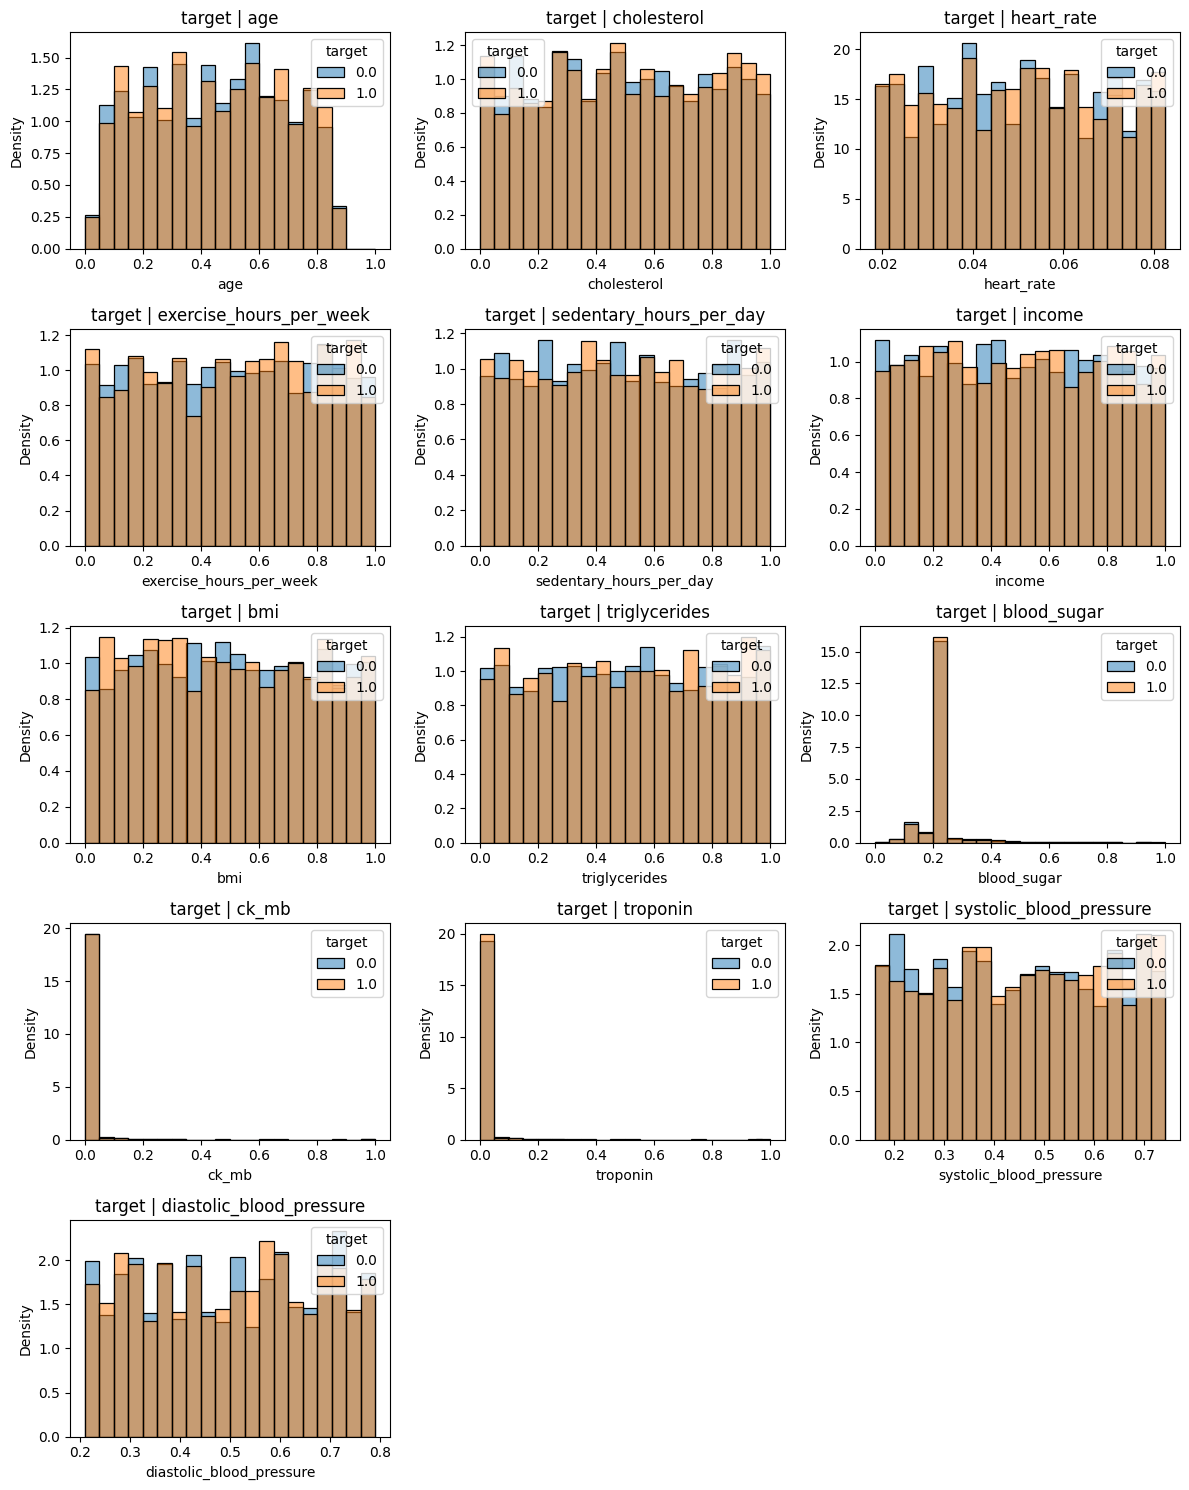

In [87]:
show_hist_list_for_fields(
    df=df_train,
    target='target',
    fields=cont_cols,
    range_map={
        "age": (0, 1),
        "blood_sugar": (0, 1),
    },
    bins_map={
       "age": 20,
       "cholesterol": 20,
       "heart_rate": 20,
       "exercise_hours_per_week": 20,
       "sedentary_hours_per_day": 20,
       "income": 20,
       "bmi": 20,
       "triglycerides": 20,
       "blood_sugar": 20,
       "ck_mb": 20,
       "troponin": 20,
       "systolic_blood_pressure": 20,
       "diastolic_blood_pressure": 20,
    },
    max_elements_in_row=3,
    figsize=(12,3),
)

- Сами по себе признаки `age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `systolic_blood_pressure`, `diastolic_blood_pressure` не вносят вклад в повышение риска сердечного приступа.

- `blood_sugar`, `ck_mb` и `troponin` требуют более детального исследования.

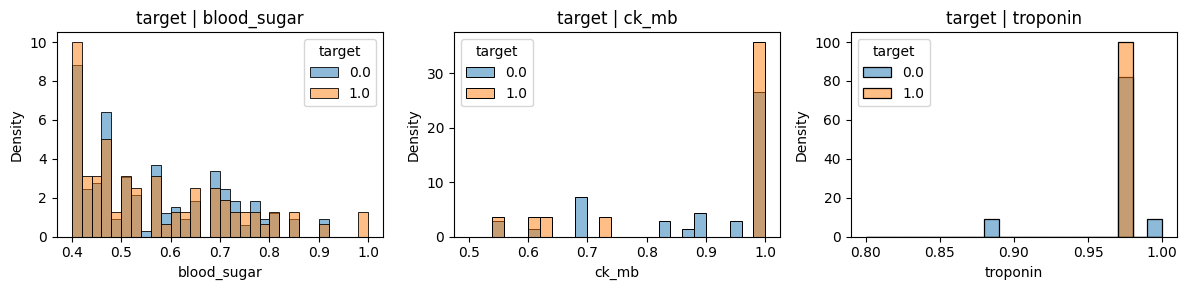

In [88]:
show_hist_list_for_fields(
    df=df_train,
    target='target',
    fields=[
        'blood_sugar',
        'ck_mb',
        'troponin',
    ],
    range_map={
        "blood_sugar": (0.4, 1),
        "ck_mb": (0.5, 1),
        "troponin": (0.8, 1),
    },
    bins_map={
       "blood_sugar": 30,
       "ck_mb": 25,
       "troponin": 20,
    },
    max_elements_in_row=3,
    figsize=(12,3),
)

- Судя по гистограммам признаков `blood_sugar`, `ck_mb` и `troponin`, они не вносят вклад в повышение риска сердечного приступа.

- Выглядит так, что все признаки очень хорошо сбалансированы, вероятно это изначально было сделано для обучения моделей и не исключено, что они могут нести синтетический характер.

Круговые диаграммы категориальных признаков для записей с сердечным приступом.

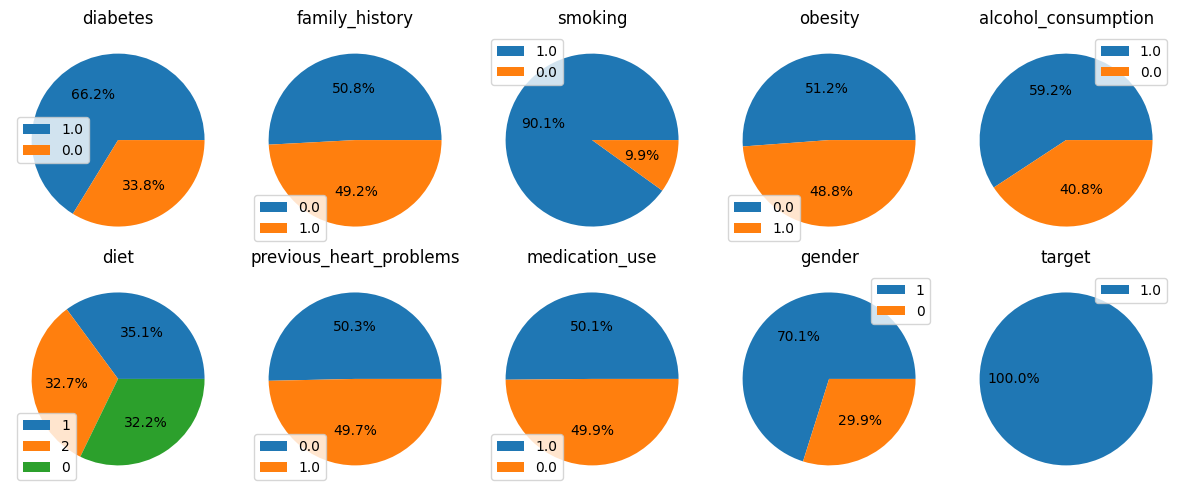

In [89]:
show_pie_for_cols(
    df=df_train[df_train['target'] == 1],
    col_names=cat_cols,
    max_elements_in_row = 5,
    figsize=(12, 5)
)

Круговые диаграммы категориальных признаков для записей без сердечного приступа.

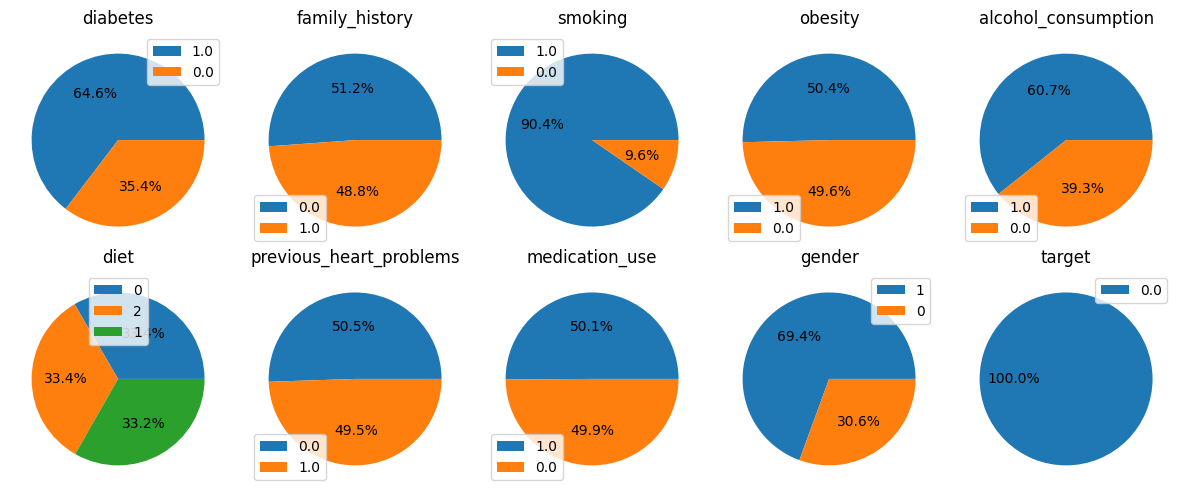

In [90]:
show_pie_for_cols(
    df=df_train[df_train['target'] == 0],
    col_names=cat_cols,
    max_elements_in_row = 5,
    figsize=(12, 5)
)

- распределения категориальных признаков в группах с и без сердечного приступа очень близки;
- по круговым диаграммам действительно нельзя сказать, что какой-то признак ярко выделяет одну из групп;
- признаки выглядят сбалансированными и не показывают сильных различий между target=1 и target=0.

### 7.6 Корреляционный анализ

Для описания тесноты связей между свойствами будет полезно воспользоваться шкалой Чеддока:

| Теснота связи  | `+`-ый коэффициент | `-`-ый коэффициент |
|----------------|--------------------|--------------------|
| Слабая         | 0.1–0.3            | (−0.1)–(−0.3)      |
| Умеренная      | 0.3–0.5            | (−0.3)–(−0.5)      |
| Заметная       | 0.5–0.7            | (−0.5)–(−0.7)      |
| Высокая        | 0.7–0.9            | (−0.7)–(−0.9)      |
| Весьма высокая | 0.9–1              | (−0.9)–(−1)        |

Подготовка таблицы содержащую коэффициенты корреляции между параметрами:

In [91]:
phik_overview = phik.phik_matrix(df_train.drop(['id'], axis=1), interval_cols=[
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'ck_mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
    'smoking',
])

Отображение матрицы корреляции:

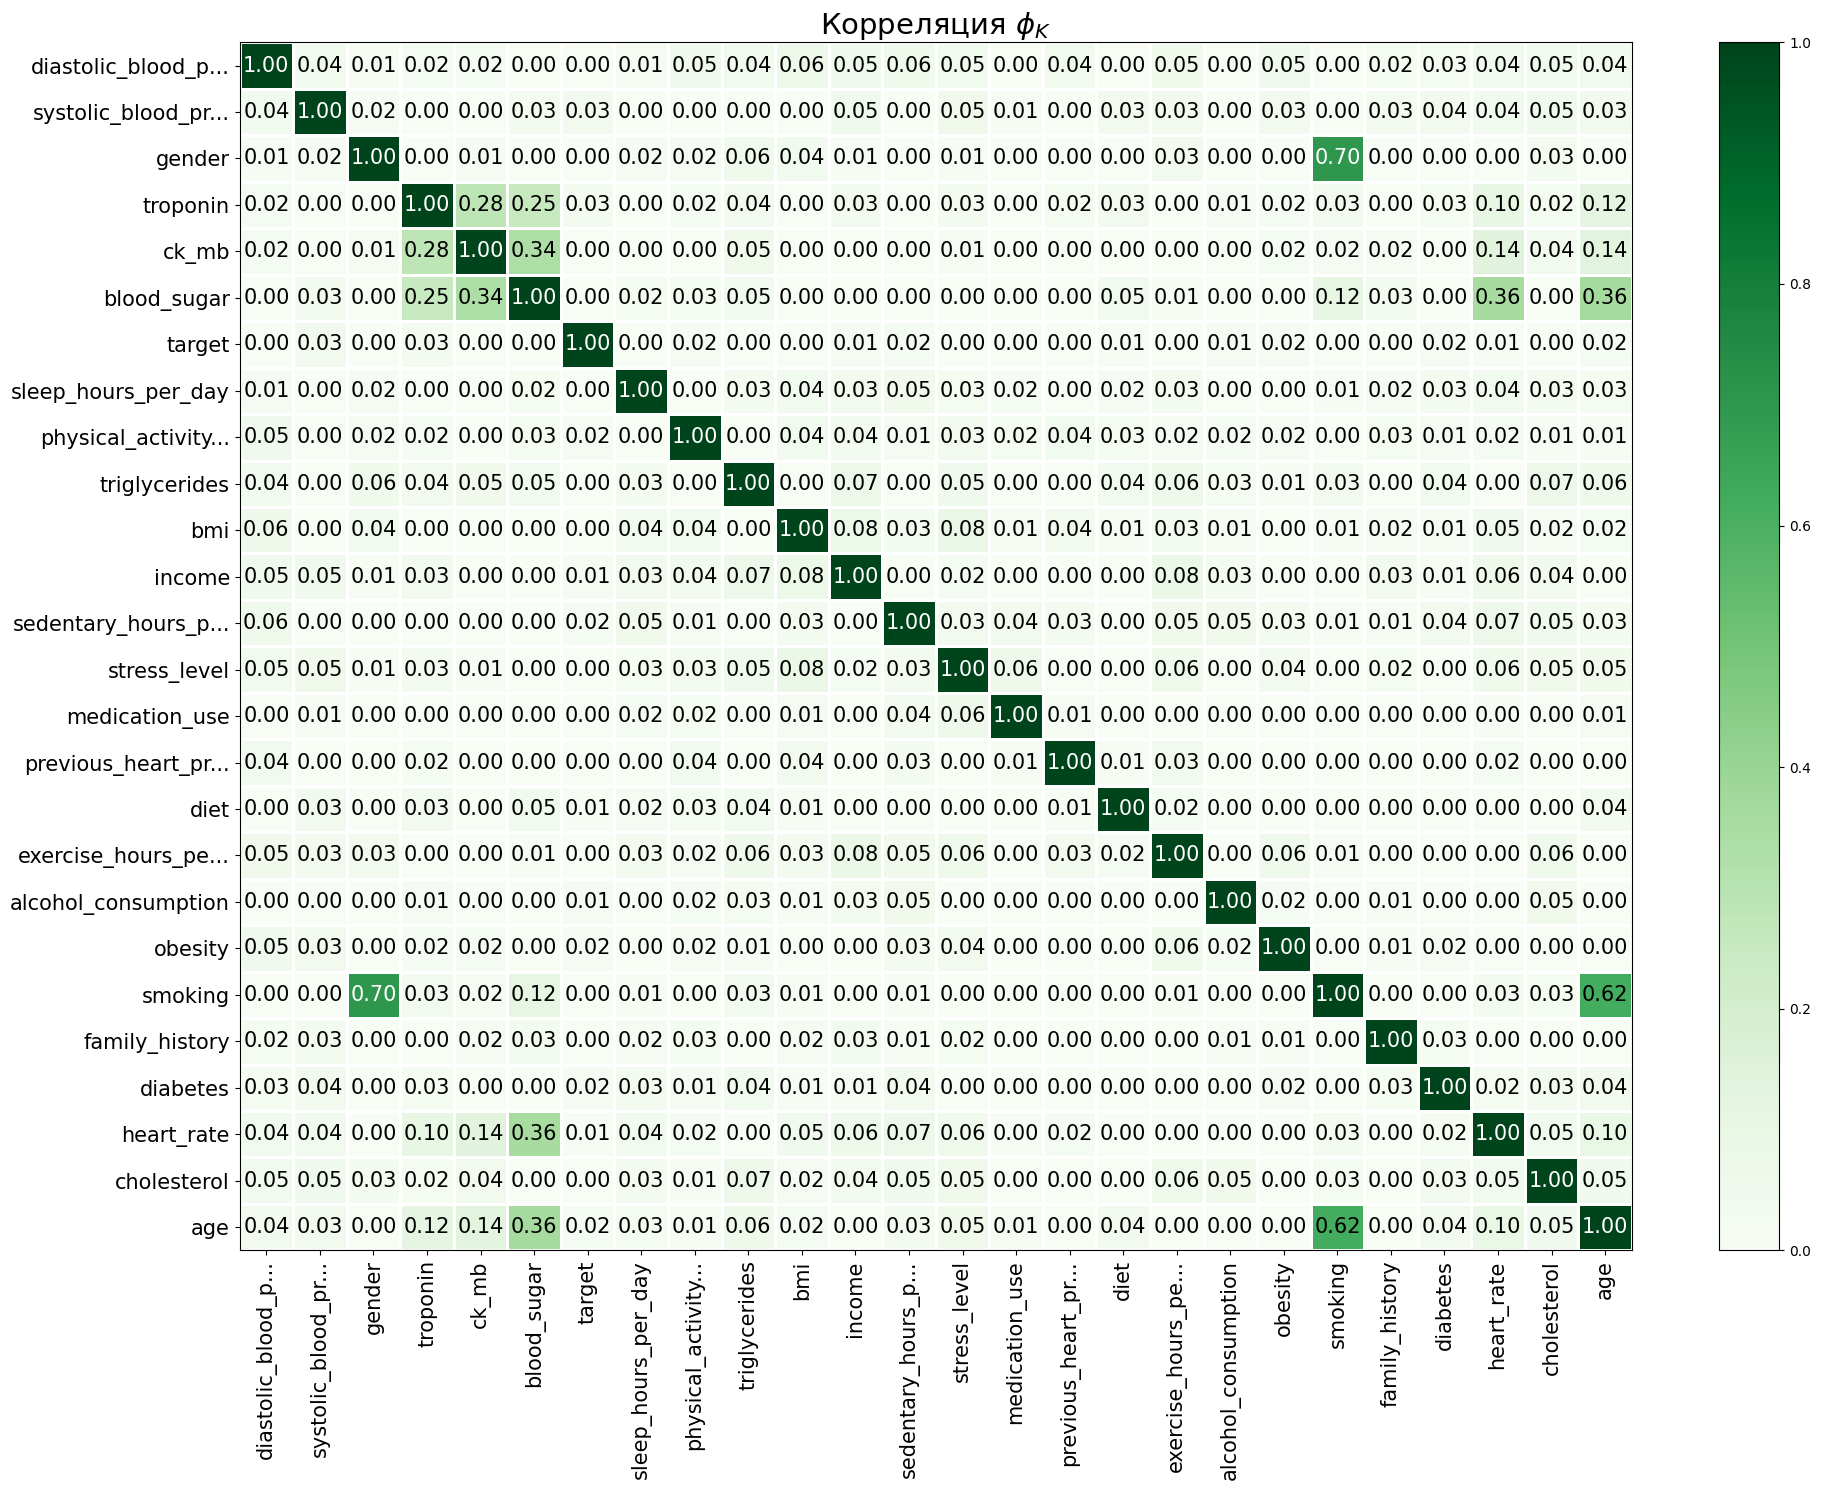

In [92]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Судя по полученной матрице выявлено, что самая высокая теснота связей между признаками `smoking` и `gender` и признаками `smoking` и `age`,

Признак `target` практически не коррелирует с другими признаками - значения коэффициентов находятся близко к нулю. Это говорит о том, что линейной или монотонной зависимости между целевой переменной и отдельными признаками нет, поэтому использование линейных моделей с высокой долей вероятности не дадут хороших результатов.

### 7.7 Исследование на мультиколлинеарность с помощью VIF

Определение функции для формирования баров позволяющих провести исследование на мультиколлинеарность с помощью VIF, где:
- `df` - исследуемая таблица;
- `num_names` - названия числовых признаков;
- `ord_cat_names` - названия уморядоченных категориальных признаков;
- `ohe_cat_names`- кодируемые неупорядоченные категориальные признаки;
- `cat_names` - исследуемые в `df` числовые признаки.

In [93]:
def show_vif_bars(df, num_names=None, ord_cat_names=None, ohe_cat_names=None):
    # Обработка числовых признаков
    if num_names is None:
        num_names = []
    if len(num_names) > 0:
        X_num_df = df[num_names]
        scaler = StandardScaler()
        X_num_scaled = scaler.fit_transform(X_num_df)
        X_num_scaled = pd.DataFrame(X_num_scaled, columns=num_names)
    else:
        X_num_scaled = pd.DataFrame()
    

    # Обработка OneHotEncoder
    if ohe_cat_names is None:
        ohe_cat_names = []
    if len(ohe_cat_names) > 0:
        X_ohe_df = df[ohe_cat_names]
        ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        X_ohe_encoded = ohe_encoder.fit_transform(X_ohe_df)
        ohe_feature_names = ohe_encoder.get_feature_names_out()
        X_ohe_encoded = pd.DataFrame(X_ohe_encoded, columns=ohe_feature_names)
    else:
        X_ohe_encoded = pd.DataFrame()

    # Объединение всех признаков
    X = pd.concat([
        X_num_scaled,
        X_ohe_encoded,
    ], axis=1)

    # Вычисление VIF
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_sorted = vif_data.sort_values(by='vif', ascending=False)

    # Визуализация
    plt.figure(figsize=(10, max(5, 0.4 * len(vif_sorted))))
    sns.barplot(data=vif_sorted, x='vif', y='feature', color='steelblue')
    plt.title("\nVIF по признакам\n", color='SteelBlue')
    plt.xlabel("VIF")
    plt.ylabel("Признак")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

В качестве входных признаков будут указаны все, кроме целевого признака `target`, чтобы искусственно не раздувать VIF, так как в первую очередь, нужно понять, есть ли признаки, которые могут быть выражены один из другого.

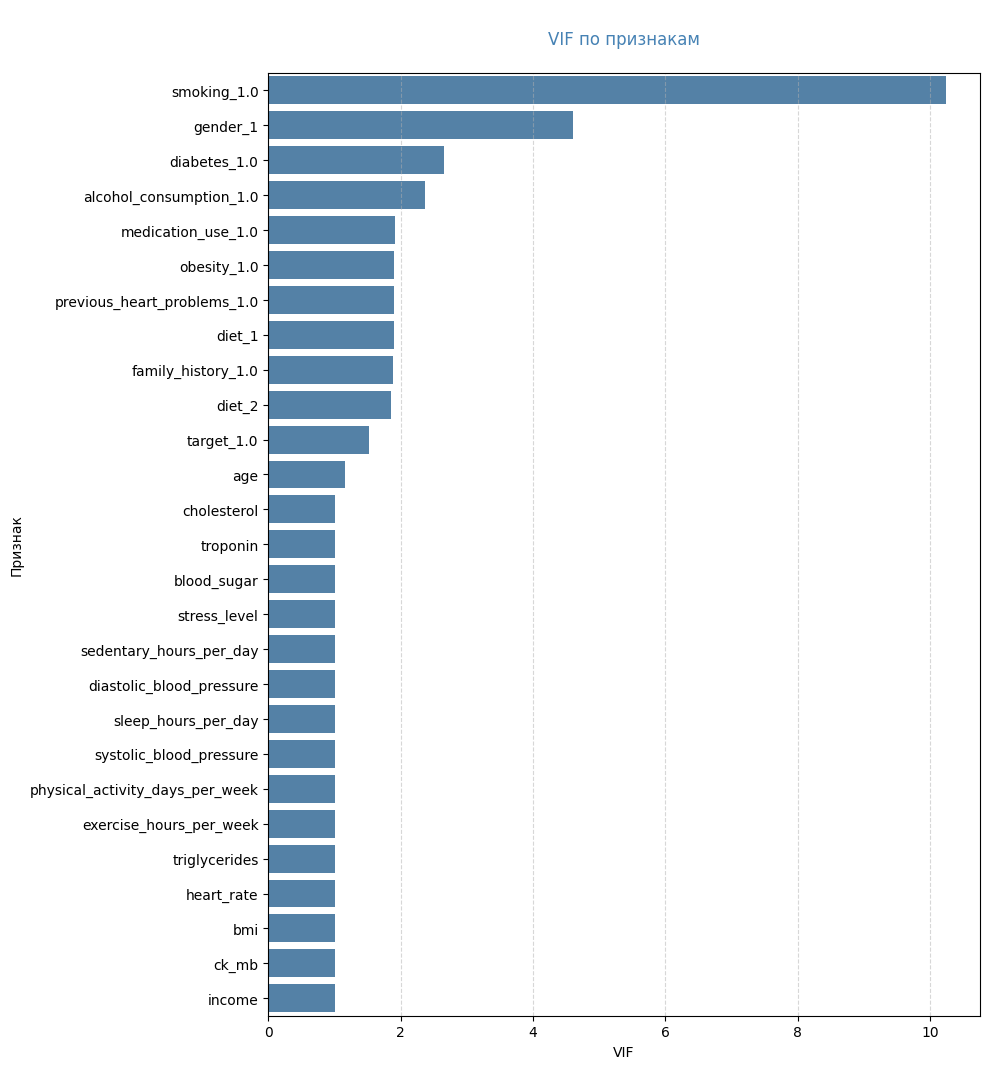

In [94]:
show_vif_bars(
    df_train.drop(['id'], axis=1),
    ohe_cat_names=[
        'diabetes',
        'family_history',
        'smoking',
        'obesity',
        'alcohol_consumption',
        'diet',
        'previous_heart_problems',
        'medication_use',
        'target',
        'gender',
    ],
    num_names=[
        'age',
        'cholesterol',
        'heart_rate',
        'exercise_hours_per_week',
        'sedentary_hours_per_day',
        'income',
        'bmi',
        'triglycerides',
        'physical_activity_days_per_week',
        'sleep_hours_per_day',
        'blood_sugar',
        'ck_mb',
        'troponin',
        'systolic_blood_pressure',
        'diastolic_blood_pressure',
        'stress_level',
    ]
)

Судя по тому, что VIF признака smoking имеет значение больше `10`, это говорит о его высокой корреляции с другими признаками. Ранее был произведён корреляционный анализ в котором было выявлено, что этот признак коррелирует с признаками `age` и `gender`. Ниже будет произведён анализ этих признаков в разрезе признака `smoking`.

In [95]:
def show_pie_for_cols_by_target(df, target, fields, figsize=(12, 3)):
    target_values = df[target].unique()
    row_count = len(fields)
    col_count = len(target_values)
    
    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=figsize)
    
    # Приведение axes к виду массива массивов для единообразного обращения
    if row_count == 1 and col_count == 1:
        axes = [[axes]]
    elif row_count == 1:
        axes = [axes]
    elif col_count == 1:
        axes = [[ax] for ax in axes]
            
    for col_index, target_value in enumerate(target_values):
        for row_index, field in enumerate(fields):
            df[df[target] == target_value][field].value_counts().plot(
                kind='pie',
                figsize=figsize,
                legend=True,
                autopct='%1.1f%%',
                labels=None,
                ax=axes[row_index][col_index],
            )
            axes[row_index][col_index].set_title(f'{target} = {target_value} | {field}')
            axes[row_index][col_index].set_ylabel('', fontsize=12)
        
    plt.tight_layout()
    plt.show()

Отображение долей курильщиков в зависимости от пола.

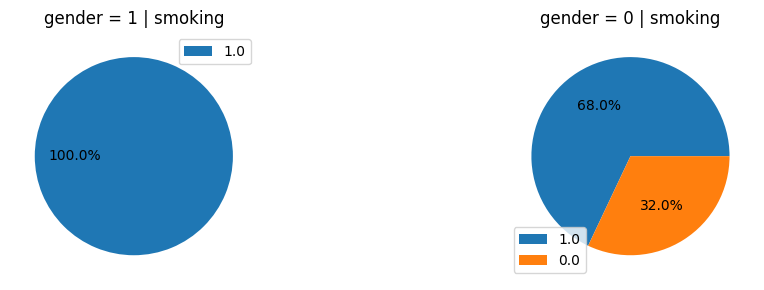

In [96]:
show_pie_for_cols_by_target(
    df=df_train,
    target='gender',
    fields=['smoking'],
)

В результате выявлено, что в обучающей выборке среди мужчин представлены лишь курильщики, среди женщин курит 68% пациентов.

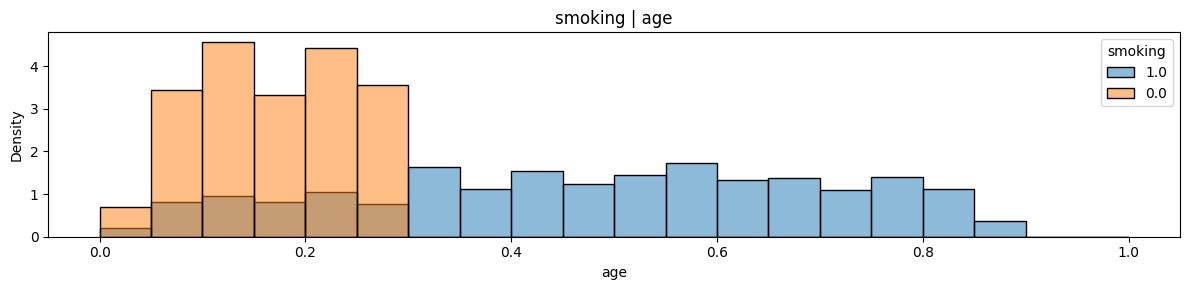

In [97]:
show_hist_list_for_fields(
    df=df_train,
    target='smoking',
    fields=['age'],
    range_map={
        "age": (0, 1),
    },
    bins_map={
       "age": 20,
    },
    max_elements_in_row=2,
    figsize=(12,3),
)

Среди пациентов, чей возрастной коэффициент выше `0.3` также представлены в основном курильщики.

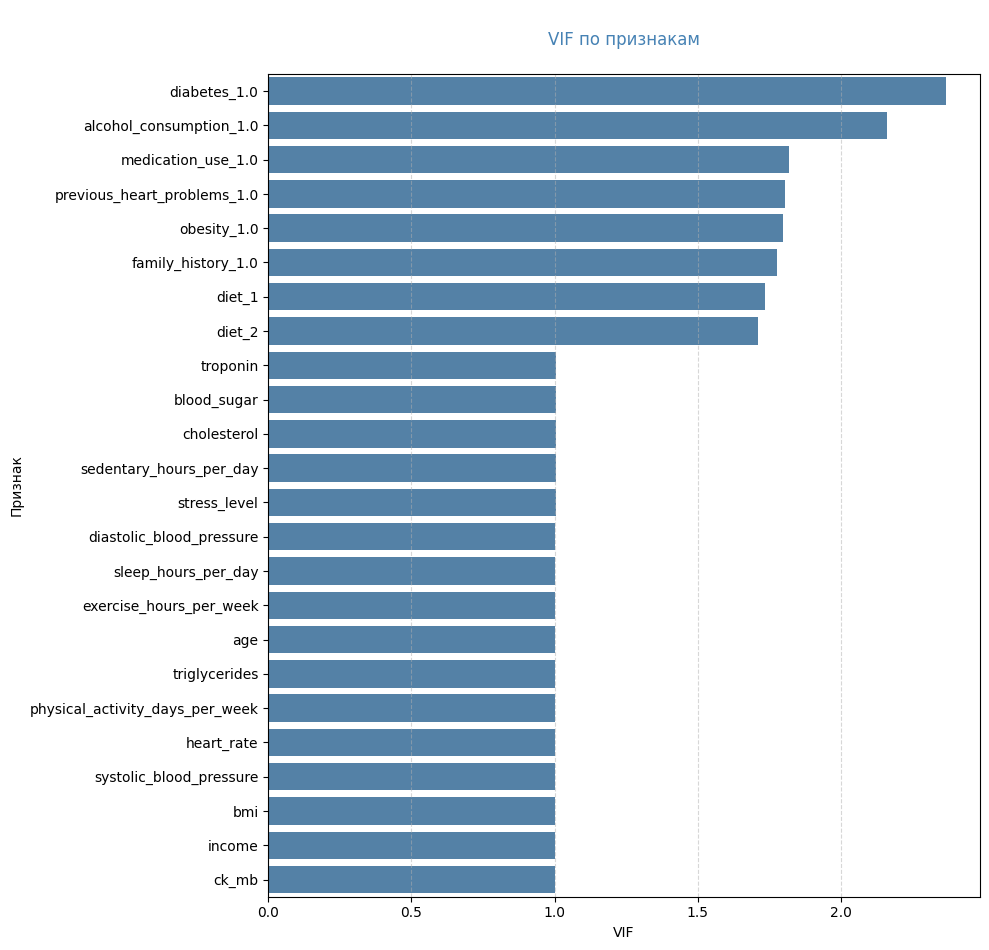

In [98]:
show_vif_bars(
    df_train.drop(['id'], axis=1),
    ohe_cat_names=[
        'diabetes',
        'family_history',
        'obesity',
        'alcohol_consumption',
        'diet',
        'previous_heart_problems',
        'medication_use',
    ],
    num_names=[
        'age',
        'cholesterol',
        'heart_rate',
        'exercise_hours_per_week',
        'sedentary_hours_per_day',
        'income',
        'bmi',
        'triglycerides',
        'physical_activity_days_per_week',
        'sleep_hours_per_day',
        'blood_sugar',
        'ck_mb',
        'troponin',
        'systolic_blood_pressure',
        'diastolic_blood_pressure',
        'stress_level',
    ]
)

## 8 Подготовка данных

Размер выборки:

In [99]:
TEST_SIZE = 0.25

In [100]:
RANDOM_STATE = 42

Подготовка признаков:

Такие признаки как `ck_mb` и `troponin`, уже предполагают то, что приступ случился, то есть это признаки с утечкой целевого признака и их нужно исключить. Признак `smoking` является важным признаком пусть и обладает сильной мультиколлинеарностью с признаком `gender`, его исключение ощутимо снижает качество модели. Также были исключены все признаки не вносящие вклад после обучения модели.

In [101]:
num_columns = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'stress_level',
    'sedentary_hours_per_day',
    'bmi',
    'triglycerides',
    'physical_activity_days_per_week',
    'sleep_hours_per_day',
    'blood_sugar',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
]

In [102]:
ohe_columns = [
    'diabetes',
    'family_history',
]

In [103]:
feature_columns = num_columns + ohe_columns

In [104]:
X = df_train[feature_columns]

Получение целевого признака:

In [105]:
y = df_train['target']

Разделение выборок на тренировочную и тестовую:

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 9 Обучение модели

### 9.1 Выбор метрики для обучения модели

Так как человеческая жизнь обладает наивысшим приоритетом, то куда более важно не пропустить случае возникновения сердечного приступа, нежели точность прогноза. В случае возникновения повышенного риска имеет смысл наблюдать пациента более внимательно, нежели в погоне за точностью предсказания допустить возникновение приступа, поэтому наибольшим приоритетом обладает метрика **полноты** (recall). Так как нужно получить максимальный показатель полноты модели без потери её точности, нужно вначале определить параметры модели, которые дадут максимальный **ROC_AUC**, которая позволит настроить порог вероятностей таким образом, чтобы получить наиболее высокий **recall**

### 9.2 Измерение метрики ROC_AUC

С помощью optuna были найдены гиперпараметры модели при которых ROC_AUC имеет лучшее значение 0.55, они и будут использованы при настройке pipeline для модели `RandomForestClassifier`. Другие модели такие как дерево решений, метод опорных векторов, к ближайших соседей имели ещё более низкие показатели метрик ROC_AUC, поэтому в качестве модели была выбрана именно `RandomForestClassifier` со следующими параметрами:

```
n_estimators=190,
max_depth=10,
min_samples_leaf=6,
min_samples_split=8,
max_features='sqrt',
class_weight='balanced_subsample',
```

### 9.3 Подготовка пайплайна

Формирование числового пайплайна, который учитывает случаи при которых одно из значений отсутсвует, также будет произведена стандартизация числовых непрерывных признаков:

In [107]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

Формирование пайплайна для подготовки неупорядоченных категориальных признаков, который учитывает случаи отсутствия значения:

In [108]:
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

Создание финального pipeline. Гиперпараметры модели выбраны в результате поиска по метрике ROC_AUC с помощью OptunaSearchCV, в силу ресурсоемкости поиска он не рпедставлен, а отражены лишь его результаты.

In [109]:
pipe_final = Pipeline([
    (
        'preprocessor',
        ColumnTransformer([
            ('num', num_pipe, num_columns),
            ('ohe', ohe_pipe, ohe_columns),
        ], remainder='passthrough')
    ),
    (
        'model',
        RandomForestClassifier(
            n_estimators=190,
            max_depth=10,
            min_samples_leaf=6,
            min_samples_split=8,
            max_features='sqrt',
            class_weight='balanced_subsample',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    )
])

### 9.4 Обучение модели и её проверка на тестовой выборке

In [110]:
rfc = pipe_final.fit(X_train, y_train)

Предсказание модели на основе тестовой выборки:

In [111]:
y_predict = rfc.predict(X_test)

Вычисление метрики полноты:

In [112]:
round(recall_score(y_test, y_predict), 2)

0.31

Вычисление метрики точности:

In [113]:
round(precision_score(y_test, y_predict), 2)

0.4

Вычисление метрики f1:

In [114]:
round(f1_score(y_test, y_predict), 2)

0.35

В результате обучения модели метрики precision и recall составляют 0.44 и 0.32 соответственно. Так как поиск моделей и гиперпараметров не увенчался успехом, то единственной что остаётся это изменить порог для получения более высокого recall.

Получение вероятностей риска сердечного приступа:

In [115]:
y_proba = rfc.predict_proba(X_test)[:, 1]

Вычисление метрики ROC_AUC для тестовой выборки:

In [116]:
round(roc_auc_score(y_test, y_proba), 2)

np.float64(0.55)

Определение функции для вычисления метрик precision, recall с пороговым значением recall:

In [117]:
def calculate_best_precision_recall_threshold(y_test, y_proba, target_recall):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    candidates = [(p, r, t) for p, r, t in zip(precisions, recalls, thresholds) if r <= target_recall]
    precision, recall, threshold = max(candidates, key=lambda x: x[1])
    return (
      round(precision, 2),
      round(recall, 2),
      round(threshold, 2),
    )

Вычисление метрик precision, recall для порогового значения recall:

In [118]:
calculate_best_precision_recall_threshold(y_test, y_proba, 0.9)

(np.float64(0.38), np.float64(0.9), np.float64(0.42))

В результате вычислено, что для recall со значением `0.9`, точность будет составлять `0.38`, при этом порог вероятностей находится на значении `0.42`. При этом метрика f1 имеет следующее значение:

In [119]:
f1_score(y_test, list(map(lambda x: x >= 0.42, y_proba)))

0.5358490566037736

## 10 Анализ важности признаков модели

### 10.1 Определение функций

In [120]:
def show_beeswarm(explainer, title='', xlabel='', ylabel=''):
    beeswarm(explainer, max_display=25, show=False)

    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=14)

    cb_ax = fig.axes[1] 

    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel(ylabel, fontsize=14)

    plt.show()

In [121]:
def show_bar(explainer, title='', xlabel='', ylabel=''):
    bar(explainer, max_display=25, show=False)
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=14)

    cb_ax = fig.axes[0] 

    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel(ylabel, fontsize=20)

    plt.show()

### 10.2 Анализ

In [122]:
model = rfc.named_steps['model'];

Получение препроцессора для подготовки данных:

In [123]:
preprocessor = rfc.named_steps['preprocessor'];

Подготовка тестовых данных с помощью этапа `preprocessor` пайплайна:

In [124]:
X_test_transformed = preprocessor.transform(X_test)

Получение названий колонок после трансформации данных:

In [125]:
feature_names = preprocessor.get_feature_names_out()

Подготовка объяснителя предсказаний на основе DecisionTreeClassifier:

In [126]:
explainer = TreeExplainer(model)

Формирование объекта для объяснения вкладов каждого из признаков:

In [127]:
shap_values = explainer(X_test_transformed)

In [128]:
shap_exp = Explanation(
    values=shap_values,
    feature_names=feature_names,
    data=X_test_transformed
)

Построение графика SHAP-beeswarm, для изучения важности признаков и вкладов в принятие решения модели:

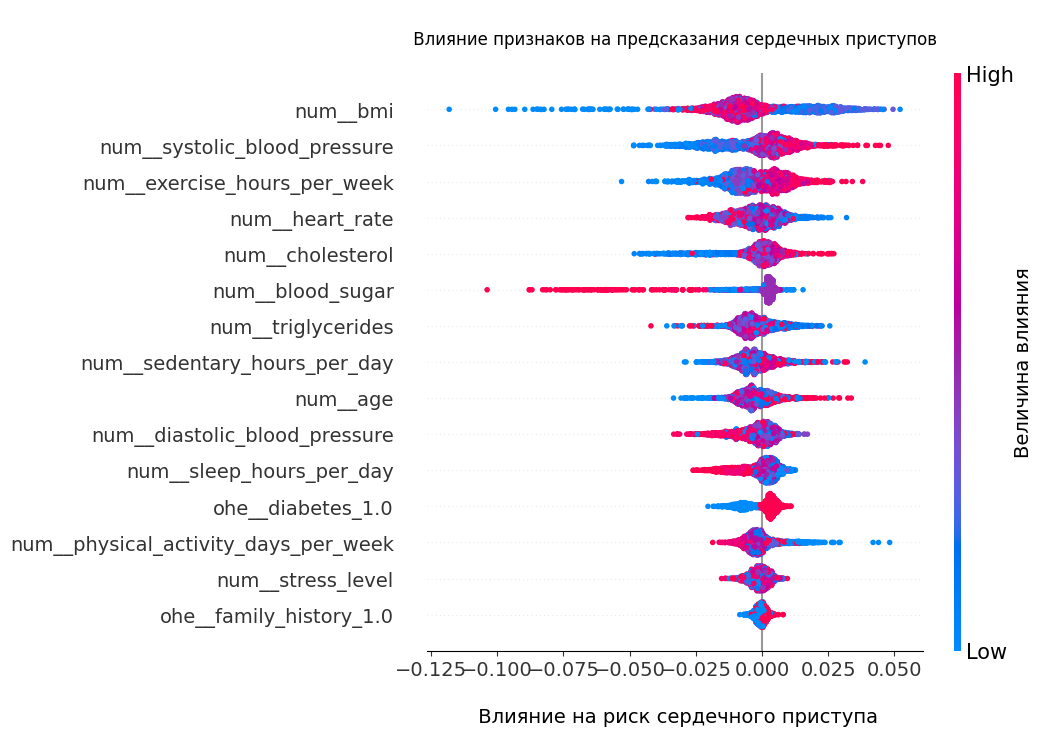

In [129]:
show_beeswarm(
    explainer=shap_exp[..., 1],
    title='\n Влияние признаков на предсказания сердечных приступов \n',
    xlabel="\n Влияние на риск сердечного приступа",
    ylabel="Величина влияния",
)

Отображение графика SHAP-bar:

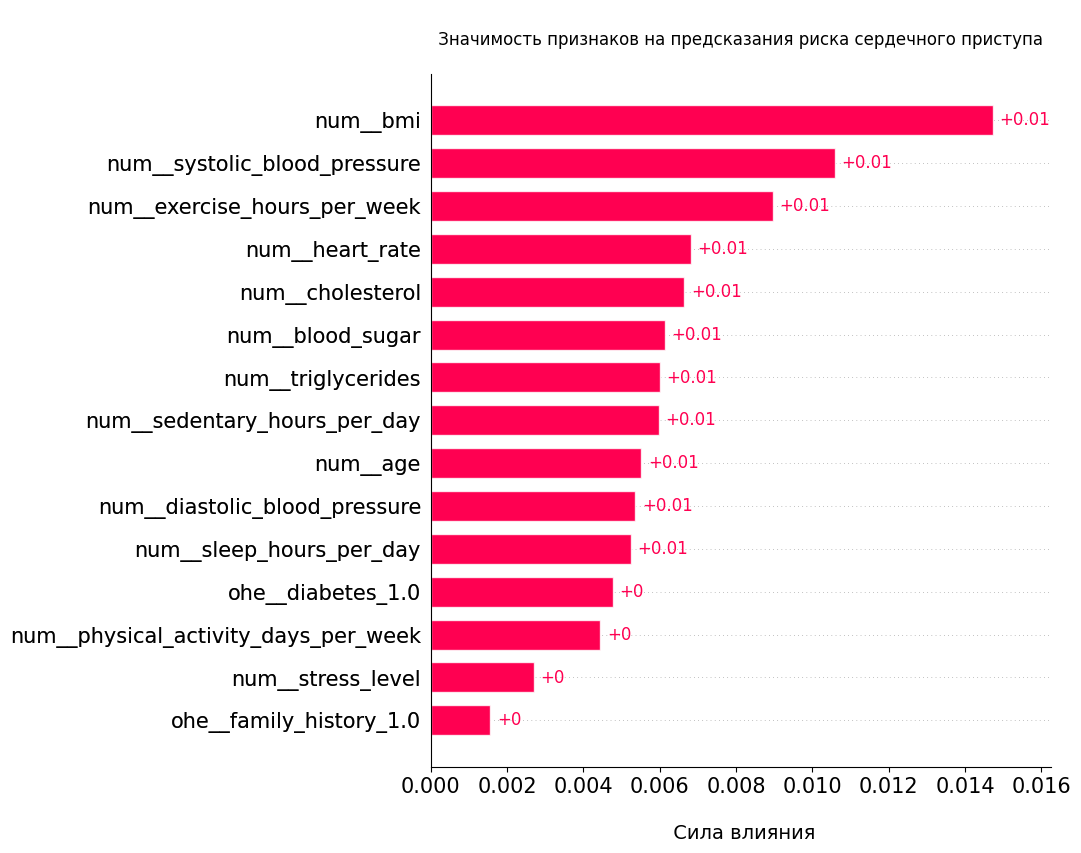

In [130]:
show_bar(
    explainer=shap_exp[..., 1],
    title='\n Значимость признаков на предсказания риска сердечного приступа \n',
    xlabel="\n Сила влияния",
)

Коэффициенты повышающие риск сердецного приступа:
- Низкий индекс массы тела. (вероятно индексы инвертированы)
- Высокие показатели верхнего и низкие показатели нижнего давления.
- Высокий показатель еженедельной физической активность.
- Высокий показатель холестерина повышает риск.
- Низкий показатель сердечных сокращений.
- Высокий показатель седячего времени в день

## 11 Запись результата в CSV

Определение порога классификации:

In [131]:
THRESHOLD_CLASSIFICATION = 0.42

Получение предсказаний для тестовой выборки:

In [132]:
y_test_proba = rfc.predict_proba(heart_test.drop(['id', 'ck_mb', 'troponin', 'income'], axis=1))[:,1]

Формирование DF предсказаний:

In [133]:
prediction = pd.DataFrame({
    'id': heart_test.id,
    'prediction': list(map(lambda x: 1 if x >= THRESHOLD_CLASSIFICATION else 0, y_test_proba)),
})

Запись предсказаний в результирующий файл:

In [134]:
prediction.to_csv("./result/predictions.csv", index=False)

## 12 Создание дампа модели

In [135]:
joblib.dump(pipe_final, "./models/0.0.1.pkl");

## 13 Вывод

В результате анализа и предварительной обработки данных было выявлено, что, несмотря на сбалансированность классов, данные содержат высокий уровень шума. Обучение различных моделей подтвердило этот вывод: значения метрики ROC AUC оказались низкими, и лучшая из моделей достигла лишь значения около `0.55`. Это всего лишь немного выше уровня случайного угадывания `0.5`, что указывает на низкое качество признаков для задачи предсказания и отсутствие чётко выраженных закономерностей в данных. Исключение признаков не привело к улучшению качества, а наоборот - дополнительно снижало и без того низкие значения метрики. 

**Рекомендации**:

Для лучшего анализа нужны декодированные данные без применения масштабирования. Вероятно могли быть ошибки в результате первоначальной очистки данных и получение признаков, таких как пол, привычка курения.

In [136]:
loaded_model = joblib.load("./models/0.0.1.pkl")

In [137]:
y_test_proba = loaded_model.predict_proba(heart_test.drop(['id', 'ck_mb', 'troponin', 'income'], axis=1))[:,1]

prediction = pd.DataFrame({
    'id': heart_test.id,
    'prediction': list(map(lambda x: 1 if x >= THRESHOLD_CLASSIFICATION else 0, y_test_proba)),
})

In [138]:
prediction

,id,prediction
0,7746,1
1,4202,1
2,6632,1
3,4639,1
4,4825,1
...,...,...
961,9271,1
962,8012,1
963,2456,1
964,4984,0


In [139]:
sklearn.__version__

'1.6.1'